#[An Image is Worth 16X16 Words: Transformers For Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)


## Students: Lila Roig, Romane Barra


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/projet_DL/"

import os
os.chdir(PATH)
print("current repository: ",PATH)

Mounted at /content/drive
current repository:  /content/drive/My Drive/projet_DL/


In [ ]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

## Introduction

**About the paper [An Image is Worth 16X16 Words: Transformers For Image Recognition at Scale](https://arxiv.org/pdf/2010.11929):**

Apply a standard Transformer directly to images.

- Transformers (and self-attention-based architectures) have dominated NLP, allowing for training on high scales.

- Computer vision traditionally relies on CNNs : the advantage are translation equivariance and locality.

- Transformers can excel, even without the inductive biases of CNNs, when they are trained on large scale data.

To do so, an image is split into patches. The sequence of linear embeddings of these patches is the input of the Transformer.

**State of the art before the 2021 article on ViTs:**
- [On the Relationship between Self-Attention and Convolutional Layers](https://arxiv.org/abs/1911.03584) : Self-attention applied on extracted patches of size 2x2.
- In the paper we study, the authors go further by demonstrating that "large scale pre-training makes vanilla transformers competitive (or even better than) state-of-the-art CNNs" and they "handle medium-resolution images as well".





## Summary of the code project

For this project, we re-implemented a Vision Transformer **(ViT) from scratch** and trained it on the **CIFAR-10 dataset**, which consists of 10 classes, 60 000 small images of 32x32 pixel.

To achieve this, we were inspired by the code provided in the original paper **[1]** as well as a tutorial **[2]**. However, we introduced several **improvements** to the existing code and added **new functions**.

Modifications made with respect to the tutorial **[2]** will be indicated by the following comment
```
### NEW ###
```

Among the modications, we can list:
- All functions have been **expentively commented**.

- We implemented the ability to stop the training at any point and **resume training** later exactly from where it was paused.

- We modified the functions to visualize the passage of an image through the neural network. We visualized the **activations** of the learned **Patch Embeddings**, the learned **weights** of the **Patch Embeddings**, the **Position Embeddings** and the **Attention Scores**.


- To improve the computation time and model performance, we implemented two strategies based on descriptions from the paper **[3]**.
  - We added **locality** to the model: Unlike CNNs, ViTs only exploit the spatial structure of images at the beginning, through the Position Embeddings, while their global attention layers ignore this structure. To address this, we added a **depth-wise 3x3 convolution** between the two linear layers of the Feed Forward module. This helps better capture the local relationships between patches. To enable this convolution, we use **Seq2Im** and **Im2Seq** layers that transform the flattened patches into 2D images before re-flattening them after the convolution.
  - **Curriculum Learning** based on image size: Curriculum learning involves starting the training with low-resolution images and gradually increasing the resolution over the epochs. In the beginning, the model is undertrained and doesn't require fine details. By progressively increasing the resolution, the model becomes capable of capturing more complex details, thus improving generalization and overall performance. An important detail is that during this gradual increase in size, the Position Embeddings must be readjusted via **interpolation** to match the new image size.

**Results**:

We trained our ViT on CIFAR-10 for **40 epochs**, achieving an **accuracy of 0.71** in **27 minutes**.

With the addition of **locality and curriculum learning**, we achieved an **accuracy of 0.86** after 40 epochs, but with a slightly longer computation time of **33 minutes**.

We believe the benefits of these two improvements would be even more pronounced on more complex datasets requiring more detailed learning.

**References**:

[1] [An Image is Worth 16X16 Words: Transformers For Image Recognition at Scale](https://arxiv.org/pdf/2010.11929)

[2] [Implementing Vision Transformer (ViT) from Scratch](https://https://towardsdatascience.com/implementing-vision-transformer-vit-from-scratch-3e192c6155f0).

[3] [Training a Vision Transformer from scratch in less than 24 hours with 1 GPU](https://https://arxiv.org/pdf/2211.05187) which provide two "tips" to train a ViT in 24 hours on a simple GPU.


## Vision Transformer

### **Transform Images into Embeddings**

The main assumptions of the ViT model are the following:
- Assumes square images: H = W.
- Assumes the image dimensions are divisible by the patch size.
- Assumes the hidden size is divisible by the number of attention heads.


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*3FzaqAt9CeQTFWxN.png" alt="Texte alternatif" width="600">

In order to feed input images to a Transformer model, we need to convert the images to a sequence of vectors. This is done by splitting the image into a grid of non-overlapping patches, which are then linearly projected to obtain a fixed-size embedding vector for each patch. We can use PyTorch's`nn.Conv2d` layer for this purpose:



In [ ]:
class PatchEmbeddings(nn.Module):
    """
    Convert the input image into patches and project each patch into a vector space.
    """

    def __init__(self, config):
        super().__init__()

        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        # Convolution for patch extraction
        self.projection = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )

    def forward(self, x, return_intermediate=False): ### NEW ###
        """
        Forward pass to extract patches and project them into the embedding space.
        """
        batch_size, num_channels, height, width = x.size() ### NEW ###

        # Dynamically calculate the number of patches based on the current image size ### NEW ###
        num_patches_calculated = (height // self.patch_size) * (width // self.patch_size) ### NEW ###

        # Apply the convolution to extract patches and project them
        conv_output = self.projection(x)

        # Flatten and reshape
        flattened_image = conv_output.flatten(2) ### NEW ###
        patch_embeddings = flattened_image.transpose(1, 2)

        # Strict Verification ### NEW ###
        if patch_embeddings.size(1) != num_patches_calculated: ### NEW ###
            raise RuntimeError( ### NEW ###
                f"[ERROR] Mismatch in number of patches. "
                f"Expected: {num_patches_calculated}, but got: {patch_embeddings.size(1)}"
            )

        if return_intermediate: ### NEW ###
            return patch_embeddings, conv_output, flattened_image ### NEW ###
        else:
            return patch_embeddings

`kernel_size=self.patch_size` and `stride=self.patch_size` are to make sure the layer's filter is applied to non-overlapping patches.

After the patches are converted to a sequence of embeddings, the `[CLS]` token is added to the beginning of the sequence, it will be used later in the classification layer to classify the image. The `[CLS]` token’s embedding is learned during training.

As patches from different positions may contribute differently to the final predictions, we also need a way to encode patch positions into the sequence. We’re going to use learnable position embeddings to add positional information to the embeddings. This is similar to how position embeddings are used in Transformer models for NLP tasks.

In [ ]:
class Embeddings(nn.Module):
    """
    Combines patch embeddings with positional embeddings and a class token for Vision Transformer (ViT).
    Supports curriculum learning by dynamically interpolating the positional embeddings as the image size grows.
    """

    def __init__(self, config):
        """
        Initializes the Embeddings module.

        Args:
            config (dict): Configuration dictionary containing:
                - image_size (int): The final size of the input image.
                - initial_image_size (int): The starting size of the input image for curriculum learning.
                - patch_size (int): The size of each patch.
                - num_channels (int): The number of channels in the input image.
                - hidden_size (int): The size of the output embedding space.
                - hidden_dropout_prob (float): Dropout probability.
        """
        super().__init__()

        # Initialize patch embeddings module
        self.patch_embeddings = PatchEmbeddings(config)
        self.hidden_size = config["hidden_size"]

        # Set initial and patch sizes ### NEW ###
        self.initial_image_size = config.get("initial_image_size", config["image_size"]) ### NEW ###
        patch_size = config["patch_size"]

        # Compute the number of patches for the initial image size ### NEW ###
        initial_num_patches = (self.initial_image_size // patch_size) ** 2 ### NEW ###

        # Initialize CLS token and positional embeddings for the smallest image size ### NEW ###
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.hidden_size))
        self.position_embeddings = nn.Parameter(
            torch.randn(1, initial_num_patches + 1, self.hidden_size) ### NEW ###
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    ### NEW FUNCTION START ###
    def interpolate_positional_embeddings(self, current_image_size):
        """
        Adjust positional embeddings using interpolation when the image size changes.
        This ensures the positional embeddings always match the number of patches.

        Args:
            current_image_size (int): The current image size during curriculum learning.
        """
        # Dynamically calculate the number of patches
        num_patches = (current_image_size // self.patch_embeddings.patch_size) ** 2

        # Only interpolate if the number of patches has changed
        if num_patches + 1 != self.position_embeddings.size(1):

            # Separate the CLS token from patch positional embeddings
            cls_token = self.position_embeddings[:, :1]
            patch_pos_emb = self.position_embeddings[:, 1:]

            # Interpolation of positional embeddings
            patch_pos_emb = patch_pos_emb.permute(0, 2, 1)  # (1, hidden_size, num_patches)
            patch_pos_emb = F.interpolate(
                patch_pos_emb, size=num_patches, mode="linear", align_corners=False
            )
            patch_pos_emb = patch_pos_emb.permute(0, 2, 1)  # (1, num_patches, hidden_size)

            # Update the positional embeddings dynamically
            self.position_embeddings = nn.Parameter(torch.cat([cls_token, patch_pos_emb], dim=1))
    ### NEW FUNCTION END ###

    def forward(self, x, current_image_size): ### NEW ###
        """
        Forward pass to prepare the embeddings for the Vision Transformer input.

        Args:
            x (Tensor): Input image tensor of shape (batch_size, num_channels, image_size, image_size).
            current_image_size (int): The current size of the image during curriculum learning.

        Returns:
            Tensor: Output embeddings of shape (batch_size, num_patches + 1, hidden_size).
        """
        # Step 1: Interpolate positional embeddings if necessary ### NEW ###
        self.interpolate_positional_embeddings(current_image_size) ### NEW ###

        # Step 2: Compute patch embeddings from input images
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()

        # Step 3: Add CLS token to the sequence
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Step 4: Debugging for dimension mismatch ### NEW ###
        if x.size(1) != self.position_embeddings.size(1): ### NEW ###
            print(f"[ERROR] Dimension mismatch detected!") ### NEW ###
            print(f"x size: {x.size(1)}") ### NEW ###
            print(f"Positional Embeddings size: {self.position_embeddings.size(1)}") ### NEW ###
            print(f"Current Image Size: {current_image_size}") ### NEW ###
            print(f"Patch Size: {self.patch_embeddings.patch_size}") ### NEW ###
            print(f"Calculated num_patches: {(current_image_size // self.patch_embeddings.patch_size) ** 2}") ### NEW ###
            raise RuntimeError(
                f"Mismatch between positional embeddings and input sequence. "
                f"x size: {x.size(1)}, pos_emb size: {self.position_embeddings.size(1)}"
            )

        # Step 5: Add positional embeddings and apply dropout
        x = x + self.position_embeddings
        x = self.dropout(x)

        return x

At this step, the input image is converted to a sequence of embeddings with positional information and ready to be fed into the transformer layer.

### **Multi-head Attention**

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*sGPEQbzPwHfT7aU3.png" alt="Texte alternatif" width="600">


Before going through the transformer encoder, we first explore the multi-head attention module, which is its core component. The multi-head attention is used to compute the interactions between different patches in the input image. The multi-head attention consists of multiple attention heads, each of which is a single attention layer.

Let’s implement a head of the multi-head attention module.
- The module takes a sequence of embeddings as input and computes query, key, and value vectors for each embedding.
- The query and key vectors are then used to compute the attention weights for each token.
- The attention weights are then used to compute new embeddings using a weighted sum of the value vectors.

We can think of this mechanism as a soft version of a database query, where the query vectors find the most relevant key vectors in the database, and the value vectors are retrieved to compute the query output.


<img src="https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/summary.png" alt="Attention Mechanism" width="600">

Here we do not implement masked Attention.


In [ ]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    Each attention head operates on the input to produce query, key, and value vectors.
    These vectors are used to calculate scaled dot-product attention.
    """

    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        """
        Initialize the AttentionHead module.

        Args:
            hidden_size (int): The size of the input embeddings (hidden size).
            attention_head_size (int): The size of the output for this attention head.
            dropout (float): Dropout probability for attention probabilities.
            bias (bool): Whether to include a bias term in the linear layers.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        # Create projection layers for query, key, and value
        # Each layer projects from hidden_size to attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key   = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass for the attention head.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).

        Returns:
            Tuple[Tensor, Tensor]:
                - Attention output of shape (batch_size, sequence_length, attention_head_size).
                - Attention probabilities of shape (batch_size, sequence_length, sequence_length).
        """
        # Project the input into query, key, and value
        # Shape: (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key   = self.key(x)
        value = self.value(x)

        # Calculate the attention scores using the scaled dot-product
        # Attention scores: Q * K^T / sqrt(attention_head_size)
        # Shape: (batch_size, sequence_length, attention_head_size) * (batch_size, attention_head_size, sequence_length)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Apply softmax to get attention probabilities
        # Shape: (batch_size, sequence_length, sequence_length)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # Apply dropout to the attention probabilities
        attention_probs = self.dropout(attention_probs)

        # Calculate the attention output: softmax(Q * K^T / sqrt(attention_head_size)) * V
        # Shape: (batch_size, sequence_length, sequence_length) * (batch_size, sequence_length, attention_head_size)
        # Result: (batch_size, sequence_length, attention_head_size)
        attention_output = torch.matmul(attention_probs, value)

        # Return the attention output and probabilities
        return (attention_output, attention_probs)

The outputs from all attention heads are then concatenated and linearly projected to obtain the final output of the multi-head attention module.

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" alt="Attention Mechanism" width="400">


We can choose to return the `attention probabilities`:

$$
\text{Attention Probs} = \text{softmax}\left(\frac{Q \cdot K^\top}{\sqrt{\text{head_size}}}\right)
$$

These probabilities have three properties:
- They are specific to each head in the multi-head attention.
- They are normalized (the sum of probabilities for each query equals 1).
- They express the relative importance of each position with respect to another.

Attention probabilities are often used to understand what the model is "paying attention to." In tasks such as image classification (Vision Transformer) or machine translation (Transformers), they help explore which parts of the input influence the predictions the most.

In the case of multi-head attention, each head has its own attention probabilities, which are stacked together to form a structure:
$$
\text{Attention Probs Shape} = (\text{batch_size, num_heads, seq_len, seq_len})
$$

Each matrix of size $\text{(seq_len, seq_len)}$ for a head describes how each position in the sequence "attends to" (or depends on) other positions.


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.

    Multi-head attention allows the model to attend to different parts of the input sequence
    simultaneously using multiple attention heads.
    """

    def __init__(self, config):
        """
        Initialize the MultiHeadAttention module.

        Args:
            config (dict): Configuration dictionary containing:
                - hidden_size: The size of the input embeddings (hidden size).
                - num_attention_heads: The number of attention heads.
                - qkv_bias: Whether to include a bias term in the query, key, and value projection layers.
                - attention_probs_dropout_prob: Dropout probability for the attention probabilities.
                - hidden_dropout_prob: Dropout probability for the attention output.
        """
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]

        # Calculate the size of each attention head
        # The hidden size must be divisible by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]

        # Create a list of attention heads
        # Each attention head is responsible for computing attention independently
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,               # Input size (hidden size)
                self.attention_head_size,       # Output size of each head
                config["attention_probs_dropout_prob"],  # Dropout probability for attention probabilities
                self.qkv_bias                   # Whether to use bias in Q, K, V projections
            )
            self.heads.append(head)

        # Create a linear layer to project the concatenated attention outputs back to the hidden size
        # This ensures the output has the same dimension as the input
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)

        # Dropout layer for regularization on the projected output
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        """
        Forward pass for the MultiHeadAttention module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
            output_attentions (bool): Whether to return attention probabilities for each head.

        Returns:
            Tuple[Tensor, Optional[Tensor]]:
                - Attention output of shape (batch_size, sequence_length, hidden_size).
                - Attention probabilities of shape (batch_size, num_attention_heads, sequence_length, sequence_length), if output_attentions is True.
        """
        # Calculate the attention output for each attention head
        # Each head computes its own attention scores and outputs independently
        # List comprehension processes each head in parallel
        attention_outputs = [head(x) for head in self.heads]

        # Concatenate the attention outputs from all heads
        # Shape: (batch_size, sequence_length, attention_head_size) * num_attention_heads
        # -> (batch_size, sequence_length, all_head_size)
        attention_output = torch.cat(
            [attention_output for attention_output, _ in attention_outputs], dim=-1
        )

        # Project the concatenated attention outputs back to the hidden size
        # Shape: (batch_size, sequence_length, all_head_size) -> (batch_size, sequence_length, hidden_size)
        attention_output = self.output_projection(attention_output)

        # Apply dropout to the projected attention output for regularization
        attention_output = self.output_dropout(attention_output)

        # Return the attention output and optionally the attention probabilities
        if not output_attentions:
            # Only return the attention output
            return (attention_output, None)
        else:
            # Stack the attention probabilities from all heads
            # Shape: (num_attention_heads, batch_size, sequence_length, sequence_length)
            # -> (batch_size, num_attention_heads, sequence_length, sequence_length)
            attention_probs = torch.stack(
                [attention_probs for _, attention_probs in attention_outputs], dim=1
            )
            return (attention_output, attention_probs)

In [ ]:
class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    This implementation is faster because it combines all query, key, and value projections
    into a single matrix multiplication.

    Classic method: In a classic multi-head attention implementation, the query (Q),
    key (K) and value (V) matrices are projected individually using three separate linear layers.
    This implies 3 separate matrix multiplications, which increases computation time.
    Optimization here: A single linear layer is used to combine the projections of Q, K, and V.
    The output of this linear layer is a large tensor containing Q, K, and V concatenated along
    the last dimension. This reduces the number of matrix operations from 3 to just 1.
    """

    def __init__(self, config):
        """
        Initialize the FasterMultiHeadAttention module.

        Args:
            config (dict): Configuration dictionary containing:
                - hidden_size: The size of the input embeddings (hidden size).
                - num_attention_heads: The number of attention heads.
                - qkv_bias: Whether to include a bias term in the query, key, and value projection layers.
                - attention_probs_dropout_prob: Dropout probability for the attention probabilities.
                - hidden_dropout_prob: Dropout probability for the attention output.
        """
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]

        # The size of each individual attention head
        # Hidden size must be divisible by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads

        # Total size of all heads combined
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Whether to use bias in query, key, and value projections
        self.qkv_bias = config["qkv_bias"]

        # Single linear layer for projecting query, key, and value together
        # Output shape is (all_head_size * 3) because it combines all three projections
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)

        # Dropout layer for regularization applied to the attention probabilities
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])

        # Linear layer to project the concatenated attention outputs back to the hidden size
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)

        # Dropout layer for regularization applied to the projected output
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        """
        Forward pass for the FasterMultiHeadAttention module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
            output_attentions (bool): Whether to return attention probabilities.

        Returns:
            Tuple[Tensor, Optional[Tensor]]:
                - Attention output of shape (batch_size, sequence_length, hidden_size).
                - Attention probabilities of shape (batch_size, num_attention_heads, sequence_length, sequence_length), if output_attentions is True.
        """
        # Step 1: Project the input tensor into combined query, key, and value matrices
        # Shape: (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)

        # Step 2: Split the combined query, key, and value into separate tensors
        # Shape: (batch_size, sequence_length, all_head_size * 3) ->
        #        (batch_size, sequence_length, all_head_size) for each of query, key, and value
        query, key, value = torch.chunk(qkv, 3, dim=-1)

        # Step 3: Reshape the query, key, and value tensors to include the number of attention heads
        # New shape: (batch_size, sequence_length, all_head_size) ->
        #            (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        # Step 4: Calculate the attention scores
        # Scaled dot-product attention: Q * K^T / sqrt(attention_head_size)
        # Shape: (batch_size, num_attention_heads, sequence_length, attention_head_size) *
        #        (batch_size, num_attention_heads, attention_head_size, sequence_length) ->
        #        (batch_size, num_attention_heads, sequence_length, sequence_length)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Step 5: Apply the softmax function to normalize the attention scores
        # Shape: (batch_size, num_attention_heads, sequence_length, sequence_length)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # Step 6: Apply dropout to the attention probabilities
        attention_probs = self.attn_dropout(attention_probs)

        # Step 7: Calculate the weighted sum of the value vectors using the attention probabilities
        # Shape: (batch_size, num_attention_heads, sequence_length, sequence_length) *
        #        (batch_size, num_attention_heads, sequence_length, attention_head_size) ->
        #        (batch_size, num_attention_heads, sequence_length, attention_head_size)
        attention_output = torch.matmul(attention_probs, value)

        # Step 8: Reshape the attention output to combine the heads back into a single tensor
        # Shape: (batch_size, num_attention_heads, sequence_length, attention_head_size) ->
        #        (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, sequence_length, self.all_head_size
        )

        # Step 9: Project the attention output back to the hidden size
        # Shape: (batch_size, sequence_length, all_head_size) -> (batch_size, sequence_length, hidden_size)
        attention_output = self.output_projection(attention_output)

        # Step 10: Apply dropout to the projected attention output
        attention_output = self.output_dropout(attention_output)

        # Return the attention output and optionally the attention probabilities
        if not output_attentions:
            # Only return the attention output
            return (attention_output, None)
        else:
            # Return the attention output and attention probabilities
            return (attention_output, attention_probs)

### **Transformer Encoder**


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*iHJ8nTDR1CpOSb-o.png" alt="Texte alternatif" width="600">


The transformer encoder is made of a stack of transformer layers. Each transformer layer mainly consists of a multi-head attention module that we just implemented and a feed-forward network. To better scale the model and stabilize training, two Layer normalization layers and skip connections are added to the transformer layer.

Let’s implement a transformer layer (referred to as `Block` in the code as it's the building block for the transformer encoder). We'll begin with the feed-forward network, which is a simple two-layer MLP with GELU activation in between.

In [ ]:
#@title classic MLP
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class MLP(nn.Module):
    """
    A multi-layer perceptron (MLP) module.

    This module consists of two fully connected layers with an activation function
    and a dropout layer in between. It is commonly used as the feed-forward network
    in Transformer architectures.
    """

    def __init__(self, config):
        """
        Initialize the MLP module.

        Args:
            config (dict): Configuration dictionary containing:
                - hidden_size (int): The size of the input and output embeddings (hidden size).
                - intermediate_size (int): The size of the intermediate layer.
                - hidden_dropout_prob (float): Dropout probability for the hidden layers.
        """
        super().__init__()

        # First fully connected layer
        # Shape: (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, intermediate_size)
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])

        # Non-linear activation function (GELU in this case)
        self.activation = NewGELUActivation()

        # Second fully connected layer
        # Shape: (batch_size, sequence_length, intermediate_size) -> (batch_size, sequence_length, hidden_size)
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])

        # Dropout layer for regularization
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        """
        Forward pass for the MLP module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).

        Returns:
            Tensor: Output tensor of shape (batch_size, sequence_length, hidden_size).
        """
        # Step 1: Apply the first dense layer
        # Shape: (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, intermediate_size)
        x = self.dense_1(x)

        # Step 2: Apply the activation function (GELU)
        # Shape remains: (batch_size, sequence_length, intermediate_size)
        x = self.activation(x)

        # Step 3: Apply the second dense layer
        # Shape: (batch_size, sequence_length, intermediate_size) -> (batch_size, sequence_length, hidden_size)
        x = self.dense_2(x)

        # Step 4: Apply dropout for regularization
        # Shape remains: (batch_size, sequence_length, hidden_size)
        x = self.dropout(x)

        # Step 5: Return the output
        return x

In [ ]:
#@title MLP with Locality
"""
Code created from the paper description: "Training a Vision Transformer from scratch in less than 24 hours with 1 GPU"
(https://arxiv.org/pdf/2211.05187) and the code from the paper
(https://github.com/BorealisAI/efficient-vit-training/blob/main/models_vit/localvit.py).

In order to introduce locality into vision Transformers,
we only adapt the FFNs while the other parts, such as self-attention and position
encoding, are not changed.

We adapt our MLP class by adding locality.
Key changes based on the paper:
- 3x3 Depth-wise Convolution: A depth-wise convolution is added between the two fully connected layers.
- Seq2Im and Im2Seq Layers: Flattening and unflattening operations around the convolution.
- Replacing GELU with h-swish: The activation function was changed to h-swish in the paper.
"""

 ### NEW CLASS START ###
class HSwishActivation(nn.Module):
    """
    Implementation of the H-Swish activation function used in the paper (https://arxiv.org/pdf/2211.05187).

    H-Swish is defined as:
        H-Swish(x) = x * ReLU6(x + 3) / 6

    It introduces smooth non-linearity and is often used in lightweight networks
    as it improves the training stability compared to standard ReLU.
    """
    def forward(self, x):
        return x * F.relu6(x + 3) / 6
 ### NEW CLASS END ###

 ### NEW CLASS START ###
class MLPWithLocality(nn.Module):
    """
    A modified MLP block with added locality using a 3x3 depth-wise convolution
    as described in the paper (https://arxiv.org/pdf/2211.05187).
    This replaces the standard GELU activation with h-swish.

    The modifications to the standard MLP include:
    - A 3x3 depth-wise convolution to capture local spatial features.
    - Conversion between flattened sequences and image-like representations (Seq2Im and Im2Seq).
    - The use of the H-Swish activation instead of GELU.
    """

    def __init__(self, config):
        """
        Initialize the modified MLP with locality.

        Args:
            config (dict): A dictionary containing model configuration parameters.
        """
        super().__init__()

        # Store essential dimensions from the config
        self.hidden_size = config["hidden_size"]  # Size of the latent dimension D
        self.patch_size = config["patch_size"]  # Patch size (P)

        # First fully connected layer (expands dimension from D to intermediate_size)
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])

        # Depth-wise convolution to introduce locality
        # - Depth-wise: Groups set to `hidden_size` meaning separate filters for each channel
        # - Kernel size: 3x3, Padding 1 to preserve spatial dimensions
        self.depthwise_conv = nn.Conv2d(
            in_channels=config["intermediate_size"],
            out_channels=config["intermediate_size"],
            kernel_size=3,
            padding=1,
            groups=config["intermediate_size"]  # Depth-wise convolution
        )

        # Activation function is h-swish instead of GELU
        self.activation = HSwishActivation()

        # Second fully connected layer (shrinks back from intermediate_size to D)
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])

        # Dropout for regularization to avoid overfitting
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def seq2im(self, x):
        """
        Converts a flattened sequence into an image grid representation (Seq -> Image),
        excluding the CLS token.

        Args:
            x: Tensor of shape (batch_size, num_patches, hidden_size)

        Returns:
            - cls_token: The CLS token (batch_size, 1, hidden_size)
            - x: The patch grid (batch_size, hidden_size, grid_height, grid_width)
        """
        batch_size, num_patches, hidden_size = x.size()

        # Separate the CLS token from the patches
        cls_token, x = x[:, 0:1], x[:, 1:]  # Extract the CLS token and patches

        # Recalculate the number of patches
        num_patches = x.size(1)
        grid_size = int(math.sqrt(num_patches))

        # Ensure the number of patches is a perfect square
        if grid_size * grid_size != num_patches:
            raise ValueError(f"Number of patches {num_patches} is not a perfect square.")

        # Convert sequence to grid format for depth-wise convolution
        x = x.transpose(1, 2).view(batch_size, hidden_size, grid_size, grid_size)
        return cls_token, x

    def im2seq(self, cls_token, x):
        """
        Converts an image grid back into a flattened sequence (Image -> Seq),
        reattaching the CLS token.

        Args:
            cls_token: The CLS token (batch_size, 1, hidden_size)
            x: Tensor of shape (batch_size, hidden_size, grid_height, grid_width)

        Returns:
            Tensor of shape (batch_size, num_patches + 1, hidden_size)
        """
        batch_size, hidden_size, grid_h, grid_w = x.size()

        # Flatten the grid and reattach the CLS token
        x = x.flatten(2).transpose(1, 2)  # Flatten to (batch_size, num_patches, hidden_size)
        x = torch.cat([cls_token, x], dim=1)  # Reattach CLS token at the beginning
        return x


    def forward(self, x):
        """
        Forward pass for the modified MLP with locality.

        Steps:
        1. Linear projection with expansion from D -> intermediate_size.
        2. Convert to image grid format (Seq2Im).
        3. Apply depth-wise convolution for locality enhancement.
        4. Convert back to sequence format (Im2Seq).
        5. Apply non-linear activation (H-Swish).
        6. Linear projection back from intermediate_size -> D.
        7. Apply dropout for regularization.

        Args:
            x: Tensor of shape (batch_size, num_patches, hidden_size).

        Returns:
            Tensor of shape (batch_size, num_patches, hidden_size).
        """
        # Step 1: First fully connected layer (D -> intermediate_size)
        x = self.dense_1(x)

        # Step 2: Convert to image grid representation for locality
        cls_token, x_image = self.seq2im(x)

        # Step 3: Apply depth-wise convolution for capturing local features
        x_image = self.depthwise_conv(x_image)

        # Step 4: Convert back to sequence format for transformer compatibility
        x = self.im2seq(cls_token, x_image)

        # Step 5: Apply the H-Swish activation function for non-linearity
        x = self.activation(x)

        # Step 6: Second fully connected layer (back to original dimension D)
        x = self.dense_2(x)

        # Step 7: Apply dropout for regularization
        x = self.dropout(x)

        # Return the final output for further transformer layers
        return x
 ### NEW CLASS END ###

We have implemented the multi-head attention and the MLP, we can combine them to create the transformer layer. The skip connections and layer normalization are applied to the input of each layer.


In [ ]:
#@title Encoder Block
class Block(nn.Module):
    """
    A single transformer block.

    This block consists of two main components:
    1. A self-attention mechanism (with support for faster multi-head attention).
    2. A feed-forward neural network (MLP).

    Both components are followed by layer normalization and use residual connections.
    """

    def __init__(self, config):
        """
        Initialize the Transformer block.

        Args:
            config (dict): Configuration dictionary containing:
                - use_faster_attention (bool): Whether to use the optimized FasterMultiHeadAttention module.
                - hidden_size (int): The size of the input embeddings (hidden size).
                - num_attention_heads (int): The number of attention heads.
                - attention_probs_dropout_prob (float): Dropout probability for attention probabilities.
                - hidden_dropout_prob (float): Dropout probability for hidden layers.
                - mlp_with_locality (bool): Whether to use the MLP with locality.
        """
        super().__init__()

        # Use FasterMultiHeadAttention if specified in the config, otherwise use the standard MultiHeadAttention
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)

        # Layer normalization applied before the self-attention mechanism
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])

        # Feed-forward network (MLP) for processing intermediate representations
        self.mlp_with_locality = config.get("mlp_with_locality", False) ### NEW ###
        if self.mlp_with_locality:
            self.mlp = MLPWithLocality(config) ### NEW ###
        else:
          self.mlp = MLP(config) ### NEW ###

        # Layer normalization applied before the feed-forward network
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        """
        Forward pass for the Transformer block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
            output_attentions (bool): Whether to return attention probabilities.

        Returns:
            Tuple[Tensor, Optional[Tensor]]:
                - Output tensor of shape (batch_size, sequence_length, hidden_size).
                - Attention probabilities of shape (batch_size, num_attention_heads, sequence_length, sequence_length), if output_attentions is True.
        """
        # Step 1: Apply layer normalization to the input before self-attention
        # Layer normalization helps stabilize training by normalizing the input
        normalized_x = self.layernorm_1(x)

        # Step 2: Compute self-attention
        # The attention mechanism focuses on relevant parts of the input sequence
        attention_output, attention_probs = self.attention(normalized_x, output_attentions=output_attentions)

        # Step 3: Add the attention output to the original input (residual connection)
        # Residual connections help preserve the original input and improve gradient flow
        x = x + attention_output

        # Step 4: Apply layer normalization before the feed-forward network (MLP)
        normalized_x = self.layernorm_2(x)

        # Step 5: Compute the output of the feed-forward network (MLP)
        mlp_output = self.mlp(normalized_x)

        # Step 6: Add the MLP output to the input of this step (residual connection)
        x = x + mlp_output

        # Step 7: Return the final output and optionally the attention probabilities
        if not output_attentions:
            # Only return the final output tensor
            return (x, None)
        else:
            # Return both the output tensor and attention probabilities
            return (x, attention_probs)

The transformer encoder stacks multiple transformer layers sequentially:

In [ ]:
#@title Encoder
class Encoder(nn.Module):
    """
    The transformer encoder module.

    This module consists of a stack of Transformer blocks. Each block processes the input through
    a self-attention mechanism and a feed-forward neural network, using residual connections and
    layer normalization to stabilize training and preserve information.
    """

    def __init__(self, config):
        """
        Initialize the Transformer encoder module.

        Args:
            config (dict): Configuration dictionary containing:
                - num_hidden_layers (int): Number of Transformer blocks in the encoder.
                - hidden_size (int): The size of the input embeddings (hidden size).
                - num_attention_heads (int): The number of attention heads.
                - attention_probs_dropout_prob (float): Dropout probability for attention probabilities.
                - hidden_dropout_prob (float): Dropout probability for hidden layers.
        """
        super().__init__()

        # Create a list to hold the Transformer blocks
        self.blocks = nn.ModuleList([])

        # Instantiate each block and add it to the list
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)  # Each block is initialized with the same configuration
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        """
        Forward pass for the Transformer encoder module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, hidden_size).
            output_attentions (bool): Whether to return attention probabilities for all blocks.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Output tensor of shape (batch_size, sequence_length, hidden_size).
                - List of attention probabilities for each block if output_attentions is True.
        """
        # Initialize a list to store attention probabilities (if needed)
        all_attentions = []

        # Pass the input through each Transformer block in sequence
        for block in self.blocks:
            # Each block processes the input and returns the output and attention probabilities
            x, attention_probs = block(x, output_attentions=output_attentions)

            # If attention probabilities are requested, store them in the list
            if output_attentions:
                all_attentions.append(attention_probs)

        # Return the final output and optionally the attention probabilities
        if not output_attentions:
            # Only return the output tensor
            return (x, None)
        else:
            # Return both the output tensor and the list of attention probabilities
            return (x, all_attentions)

### **ViT for image classification**

After inputting the image to the embedding layer and transformer encoder, we obtain new embeddings for both the image patches and the [CLS] token. At this point, the embeddings should have some useful signals for classification after being processed by the transformer encoder. Similar to BERT, we’ll use only the [CLS] token’s embedding to pass to the classification layer.

The classification layer is a fully connected layer that takes the [CLS] embedding as input and outputs logits for each image. The following code implements the ViT model for image classification:



In [ ]:
class ViTForClassfication(nn.Module):
    """
    The ViT (Vision Transformer) model for classification.

    This model uses a Transformer architecture to process images as a sequence of patches,
    followed by a classification head for tasks such as image classification.
    """

    def __init__(self, config):
        """
        Initialize the Vision Transformer for classification.

        Args:
            config (dict): Configuration dictionary containing:
                - image_size (int): The size of the input image (assumes square images).
                - hidden_size (int): The size of the hidden layer in the Transformer.
                - num_classes (int): The number of output classes for classification.
                - num_hidden_layers (int): The number of Transformer blocks in the encoder.
                - num_attention_heads (int): The number of attention heads in the Transformer.
                - attention_probs_dropout_prob (float): Dropout probability for attention probabilities.
                - hidden_dropout_prob (float): Dropout probability for hidden layers.
                - initializer_range (float): Range for initializing weights.
        """
        super().__init__()
        self.config = config

        # Store the model's configuration parameters
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]

        # Step 1: Create the embedding module to process input images
        self.embedding = Embeddings(config)

        # Step 2: Create the Transformer encoder module
        self.encoder = Encoder(config)

        # Step 3: Create a classification head
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)

        # Step 4: Initialize all model weights
        self.apply(self._init_weights)

    def forward(self, x, current_image_size=None, output_attentions=False): ### NEW ###
        """
        Forward pass for the Vision Transformer for classification.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_channels, image_size, image_size).
            output_attentions (bool): Whether to return attention probabilities for all encoder blocks.
            current_image_size (int): The current size of the input image (for curriculum learning). ### NEW ###

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Logits tensor of shape (batch_size, num_classes).
                - List of attention probabilities for each block if output_attentions is True.
        """
        # Step 1: Calculate the embedding output from the input image
        embedding_output = self.embedding(x, current_image_size) ### NEW ###

        # Step 2: Process the embeddings through the Transformer encoder
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)

        # Step 3: Extract the [CLS] token's output for classification
        logits = self.classifier(encoder_output[:, 0, :]) ### NEW ###

        # Step 4: Return the logits and optionally the attention probabilities
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        """
        Initialize the weights of the model.

        Args:
            module (nn.Module): The module to initialize.
        """
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"]
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"]
            ).to(module.cls_token.dtype)


## Prepare Data

In [ ]:
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None,
                 initial_image_size=8, final_image_size=32, curriculum_epochs=10, patch_size=4):
    """
    Prepare data loaders for the CIFAR-10 dataset with optional curriculum learning.

    Curriculum Learning: The image size starts small and gradually increases to the full size.

    Args:
        batch_size (int): Number of samples per batch for training and testing.
        num_workers (int): Number of worker threads for data loading (for parallel data loading).
        train_sample_size (int, optional): Number of training samples to use (for faster debugging or limited training data).
        test_sample_size (int, optional): Number of test samples to use (for faster debugging or limited test data).
        initial_image_size (int): Starting image size for curriculum learning. ### NEW ###
        final_image_size (int): Final image size after curriculum learning completes. ### NEW ###
        curriculum_epochs (int): Number of epochs over which the image size is gradually increased. ### NEW ###
        patch_size (int): Patch size for ensuring the image size remains divisible by this factor. ### NEW ###

    Returns:
        tuple: A tuple containing:
            - curriculum_trainloader (function): Function to get the train DataLoader with curriculum learning applied. ### NEW ###
            - curriculum_testloader (function): Function to get the test DataLoader with dynamic resizing. ### NEW ###
            - classes (tuple): CIFAR-10 class labels.
    """
    ### NEW FUNCTION START ###
    def get_curriculum_transform(epoch):
        """
        Generate a transformation for curriculum learning based on the current epoch.
        The image size increases progressively across epochs.
        """
        #current_image_size = int(initial_image_size + (final_image_size - initial_image_size) * (epoch / curriculum_epochs))
        #current_image_size = (current_image_size // patch_size) * patch_size
        #current_image_size = max(initial_image_size, min(current_image_size, final_image_size))

        if epoch < curriculum_epochs:
            # Gradual increase during the first curriculum_epochs
            current_image_size = int(initial_image_size + (final_image_size - initial_image_size) * (epoch / (curriculum_epochs - 1)))
        else:
            # Hold the final size constant after curriculum_epochs
            current_image_size = final_image_size

        # Ensure the size is a multiple of the patch size for consistency
        current_image_size = (current_image_size // patch_size) * patch_size
        current_image_size = max(initial_image_size, min(current_image_size, final_image_size))


        return transforms.Compose([
            transforms.Resize((current_image_size, current_image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]), current_image_size
    ### NEW FUNCTION END ###

    ### NEW FUNCTION START ###
    def curriculum_testloader(epoch):
        test_transform, current_image_size = get_curriculum_transform(epoch)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        if test_sample_size:
            indices = torch.randperm(len(testset))[:test_sample_size]
            testset = torch.utils.data.Subset(testset, indices)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        return testloader, current_image_size
    ### NEW FUNCTION END ###

    ### NEW FUNCTION START ###
    def curriculum_trainloader(epoch):
        train_transform, current_image_size = get_curriculum_transform(epoch)
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        if train_sample_size:
            indices = torch.randperm(len(trainset))[:train_sample_size]
            trainset = torch.utils.data.Subset(trainset, indices)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        return trainloader, current_image_size
    ### NEW FUNCTION END ###

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return curriculum_trainloader, curriculum_testloader, classes

## Utils

In [ ]:
def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, completed_epochs, current_image_size, base_dir="experiments"):
    """
    Save an experiment's configuration, metrics, and model to a specified directory.

    Args:
        experiment_name (str): Name of the experiment.
        config (dict): Configuration dictionary for the experiment.
        model (nn.Module): The trained model to save.
        train_losses (list): List of training loss values.
        test_losses (list): List of test loss values.
        accuracies (list): List of accuracy values.
        completed_epochs (int): The number of epochs completed so far.
        current_image_size (int): The current image size used during training. ### NEW ###
        base_dir (str): Base directory for saving experiments. Default is "experiments".
    """
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config as a JSON file
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics as a JSON file, including the number of completed epochs and current image size
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
            'completed_epochs': completed_epochs, ### NEW ###
            'current_image_size': current_image_size ### NEW ###
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model's state dictionary
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)

def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    """
    Save a checkpoint of the model's state dictionary.

    Args:
        experiment_name (str): Name of the experiment.
        model (nn.Module): The model to save.
        epoch (str or int): Identifier for the checkpoint (e.g., epoch number or "final").
        base_dir (str): Base directory for saving checkpoints. Default is "experiments".
    """
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)

def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):

    # Detect device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ### NEW ###
    print(f"Using device: {device}") ### NEW ###

    outdir = os.path.join(base_dir, experiment_name)

    # Charger la configuration et les métriques
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)

    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        metrics = json.load(f)

    train_losses = metrics['train_losses']
    test_losses = metrics['test_losses']
    accuracies = metrics['accuracies']
    completed_epochs = metrics.get('completed_epochs', 0) ### NEW ###
    current_image_size = metrics.get('current_image_size', config.get('final_image_size')) ### NEW ###
    patch_size = config["patch_size"]

    # Important : forcer initial_image_size à current_image_size
    config["initial_image_size"] = current_image_size ### NEW ###

    # Calcul dynamique du nombre de patches
    num_patches = (current_image_size // patch_size) ** 2 ### NEW ###

    # Charger les poids **avant** de créer le modèle
    cpfile = os.path.join(outdir, checkpoint_name)
    state_dict = torch.load(cpfile, map_location=device, weights_only=False)

    # Créer le modèle avec la taille d'image corrigée
    model = ViTForClassfication(config)

    # Appliquer les poids ajustés
    try:
        model.load_state_dict(state_dict, strict=True)
        print("Model loaded successfully!")
    except RuntimeError as e:
        print(f"[WARNING] Partial mismatch detected. Attempting partial load...")
        model.load_state_dict(state_dict, strict=False)

    # Déplacement sur le bon device
    model = model.to(device) ### NEW ###

    # Retourner toutes les variables correctement
    return config, model, train_losses, test_losses, accuracies, completed_epochs, current_image_size

def visualize_images():
    """
    Visualize a random subset of 30 images from the CIFAR-10 training set.

    This function randomly selects 30 images from the CIFAR-10 dataset and displays them
    along with their corresponding class labels.
    """
    # Load the CIFAR-10 training dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

    # Define class names for CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Randomly select 30 samples from the dataset
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]

    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


## Visualise Dataset

Files already downloaded and verified


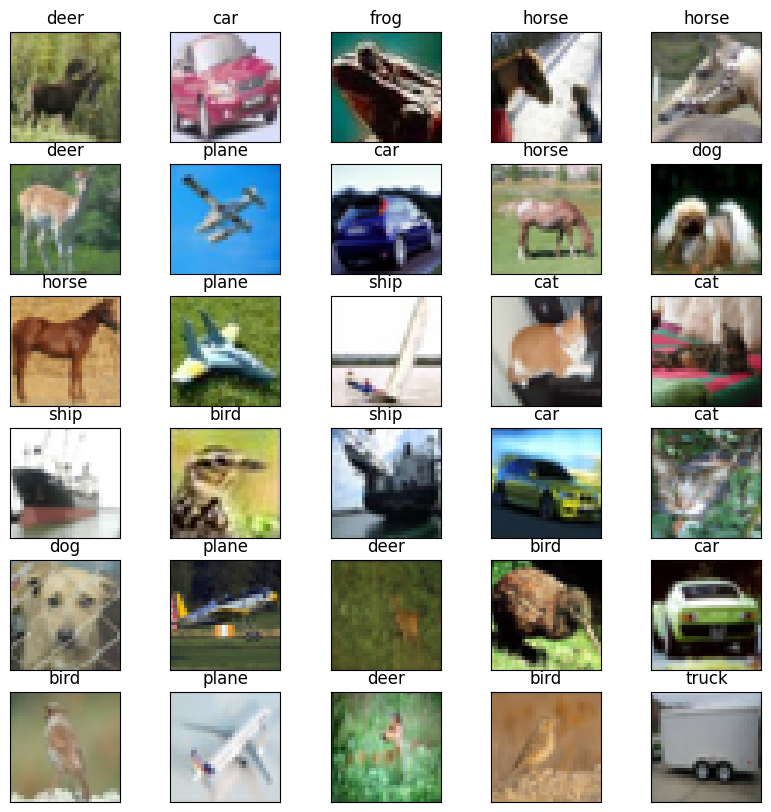

In [ ]:
# Show some training images
visualize_images()

## Train ViT

In [ ]:
#@title Trainer
class Trainer:
    """
    A Trainer class with curriculum learning support and ability to resume training.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device, config):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.config = config
        self.curriculum_learning = config.get("use_curriculum_learning", False) ### NEW ###
        self.initial_image_size = config.get("initial_image_size", 8) ### NEW ###
        self.current_image_size = self.initial_image_size  # Added to track the current size ### NEW ###

    def train(self, curriculum_trainloader, curriculum_testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs with optional curriculum learning.
        """
        train_losses, test_losses, accuracies = [], [], []

        # Attempt to load previous training state if resuming ### NEW ###
        completed_epochs = 0
        try:
            _, _, train_losses, test_losses, accuracies, completed_epochs, self.current_image_size = load_experiment(self.exp_name) ### NEW ###
            print(f"Resuming from epoch {completed_epochs} with image size {self.current_image_size}") ### NEW ###
        except FileNotFoundError:
            pass  # Start from scratch if no saved experiment is found

        for epoch in range(completed_epochs, completed_epochs + epochs):
            print(f"\nStarting epoch {epoch + 1}/{completed_epochs + epochs}. Using image size {self.current_image_size}x{self.current_image_size}") ### NEW ###

            # Curriculum Learning Management ### NEW ###
            if self.curriculum_learning:
                trainloader, self.current_image_size = curriculum_trainloader(epoch)
                testloader, _ = curriculum_testloader(epoch)
            else:
                trainloader, _ = curriculum_trainloader(0)
                testloader, _ = curriculum_testloader(0)

            # Perform a training step
            train_loss = self.train_epoch(trainloader, current_image_size=self.current_image_size) ### NEW ###
            accuracy, test_loss = self.evaluate(testloader, current_image_size=self.current_image_size) ### NEW ###

            # Collect metrics
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)

            # Logging progress
            print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

            # Save checkpoint periodically
            if save_model_every_n_epochs > 0 and (epoch + 1) % save_model_every_n_epochs == 0:
                print(f"Saving checkpoint at epoch {epoch + 1}") ### NEW ###
                save_checkpoint(self.exp_name, self.model, epoch + 1)
                save_experiment(self.exp_name,self.config,self.model,train_losses,test_losses, accuracies, epoch + 1, self.current_image_size)
        # Final save
        print(f"Saving final model and metrics...") ### NEW ###
        save_experiment(self.exp_name,self.config,self.model,train_losses,test_losses, accuracies, epoch + 1, self.current_image_size)
        print(f"Training completed!") ### NEW ###

    def train_epoch(self, trainloader, current_image_size): ### NEW ###
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0

        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch

            self.optimizer.zero_grad()
            logits, _ = self.model(images, current_image_size=current_image_size) ### NEW ###

            # Loss Calculation
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)

        avg_loss = total_loss / len(trainloader.dataset)
        return avg_loss

    @torch.no_grad()
    def evaluate(self, testloader, current_image_size): ### NEW ###
        """
        Evaluate the model on the test set.
        """
        self.model.eval()
        total_loss = 0
        correct = 0

        for batch in testloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch

            logits, _ = self.model(images, current_image_size=current_image_size) ### NEW ###

            # Loss and Accuracy Calculation
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()

        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)

        return accuracy, avg_loss


In [ ]:
#@title Config
exp_name = 'vit-with-40-epochs-locality-curriculum'
batch_size = 32
epochs = 40
lr = 1e-2
save_model_every = 1  # Save model checkpoint every N epochs

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    # Vision Transformer architecture parameters
    "patch_size": 4, # Patch size for image splitting (32x32 -> 8x8 patches)
    "hidden_size": 48,  # Size of the hidden layer embeddings
    "num_hidden_layers": 4,  # Number of transformer layers
    "num_attention_heads": 4,  # Number of attention heads in each layer
    "intermediate_size": 4 * 48,  # Size of the intermediate MLP layer (4x hidden size)
    "hidden_dropout_prob": 0.0,  # Dropout probability for hidden layers
    "attention_probs_dropout_prob": 0.0,  # Dropout for attention probabilities
    "initializer_range": 0.02,  # Weight initialization range
    "num_classes": 10,  # Number of classes in CIFAR-10
    "num_channels": 3,  # Number of channels in input images (RGB)
    "qkv_bias": True,  # Use bias in QKV projections for attention layers
    "use_faster_attention": True,  # Use optimized multi-head attention
    "mlp_with_locality": True,  # Use the MLP with added locality (depthwise convolutions)

    # Training parameters
    "exp_name": exp_name,  # Experiment name for saving checkpoints and logs
    "batch_size": batch_size,  # Batch size for training
    "epochs": epochs,  # Total number of epochs for training
    "lr": lr,  # Learning rate for the optimizer
    "save_model_every": save_model_every,  # Frequency for saving model checkpoints
    "device": device,  # Device to use for training ("cuda" or "cpu")

    # Curriculum Learning Parameters
    "use_curriculum_learning": True,  # Enable curriculum learning
    "initial_image_size": 8,  # Initial image size for curriculum learning
    "final_image_size": 32,  # Final image size (full CIFAR-10 resolution)
    "image_size": 32,  # Final image size for the model
    "curriculum_epochs": 10,  # Number of epochs over which image size grows
}

# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

In [ ]:
#@title Main
### NEW FUNCTION START ###
def main(exp_name, checkpoint_name="model_final.pt", base_dir="experiments", additional_epochs=None):
    """
    Main function to train or resume training a Vision Transformer (ViT) model with curriculum learning support.

    Args:
        exp_name (str): Name of the experiment to train or resume.
        checkpoint_name (str): Name of the checkpoint file to load if resuming. Default is "model_final.pt".
        base_dir (str): Base directory where the experiments are saved. Default is "experiments".
        additional_epochs (int, optional): Number of additional epochs to train if resuming. If None, defaults to completing the total epochs specified in the config.
    """
    print(f"\nStarting main function for experiment: {exp_name}")
    experiment_path = os.path.join(base_dir, exp_name)

    # Check if the experiment already exists
    if os.path.exists(experiment_path):
        print(f"Experiment '{exp_name}' found. Attempting to resume training...")

        # Load the previous experiment state
        loaded_config, model, train_losses, test_losses, accuracies, completed_epochs, current_image_size = load_experiment(
            exp_name, checkpoint_name=checkpoint_name, base_dir=base_dir
        )
        print(f"Loaded checkpoint. Completed epochs: {completed_epochs}, Current image size: {current_image_size}")

        # Verify configuration consistency
        if loaded_config != config:
            print("Warning: Loaded config differs from the current config.")
            print(f"Loaded config: {loaded_config}")
            print(f"Current config: {config}")

        # Print spec
        print(f"\nUse Faster Attention: {loaded_config.get('use_faster_attention')}")
        print(f"Use MLP with locality: {loaded_config.get('mlp_with_locality')}")
        print(f"Use curriculum learning: {loaded_config.get('use_curriculum_learning')}\n")

        # Extract hyperparameters
        batch_size = loaded_config.get("batch_size", 128)
        lr = loaded_config.get("lr", 1e-3)
        total_epochs = loaded_config.get("epochs", 10)
        save_model_every_n_epochs = loaded_config.get("save_model_every", 1)
        initial_image_size = loaded_config.get("initial_image_size", 8)
        final_image_size = loaded_config.get("final_image_size", 32)
        curriculum_epochs = loaded_config.get("curriculum_epochs", 10)

        # Calculate remaining epochs
        if additional_epochs is not None:
            epochs_remaining = additional_epochs
            total_epochs += additional_epochs
            loaded_config["epochs"] = total_epochs
            print(f"Additional epochs requested. Total epochs updated to: {total_epochs}")
        else:
            epochs_remaining = total_epochs - completed_epochs
            print(f"Calculated remaining epochs: {epochs_remaining}")

        # Prepare the data loaders
        curriculum_trainloader, curriculum_testloader, _ = prepare_data(
            batch_size=batch_size,
            initial_image_size=initial_image_size,
            final_image_size=final_image_size,
            curriculum_epochs=curriculum_epochs,
        )

        # Initialize model and trainer
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
        loss_fn = nn.CrossEntropyLoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device, config=loaded_config)
        trainer.current_image_size = current_image_size

        # Resume training if required
        if epochs_remaining > 0:
            print(f"Resuming training for {epochs_remaining} epochs...")
            trainer.train(
                curriculum_trainloader, curriculum_testloader,
                epochs=epochs_remaining,
                save_model_every_n_epochs=save_model_every_n_epochs
            )
        else:
            print("Training already completed. No remaining epochs to train.")

    # If no experiment exists, start training from scratch
    else:
        print(f"Experiment '{exp_name}' not found. Starting new training from scratch.")

        # Print spec
        print(f"\nUse Faster Attention: {config.get('use_faster_attention')}")
        print(f"Use MLP with locality: {config.get('mlp_with_locality')}")
        print(f"Use curriculum learning: {config.get('use_curriculum_learning')}\n")

        # Load hyperparameters from config
        batch_size = config.get("batch_size", 128)
        lr = config.get("lr", 1e-3)
        epochs = config.get("epochs", 10)
        save_model_every_n_epochs = config.get("save_model_every", 1)
        initial_image_size = config.get("initial_image_size", 8)
        final_image_size = config.get("final_image_size", 32)
        curriculum_epochs = config.get("curriculum_epochs", 10)

        # Prepare data loaders
        curriculum_trainloader, curriculum_testloader, _ = prepare_data(
            batch_size=batch_size,
            initial_image_size=initial_image_size,
            final_image_size=final_image_size,
            curriculum_epochs=curriculum_epochs,
        )

        # Initialize model and trainer
        model = ViTForClassfication(config)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
        loss_fn = nn.CrossEntropyLoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize trainer with dynamic test loader
        trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device, config=config)
        trainer.current_image_size = initial_image_size

        # Start training from scratch
        print(f"Starting full training for {epochs} epochs...")
        trainer.train(
            curriculum_trainloader, curriculum_testloader,
            epochs=epochs,
            save_model_every_n_epochs=save_model_every_n_epochs
        )

    # Completion message
    print(f"\nTraining complete for experiment: {exp_name}")

### NEW FUNCTION END ###

In [ ]:
#@title Launch Training
# Train model
# --------------------
import time
if __name__ == '__main__':
    # Mesure du temps de début
    start_time = time.time()

    # Lancement de l'entraînement avec la fonction principale
    main(exp_name="my_experiment", checkpoint_name="model_final.pt", base_dir="experiments", additional_epochs=2)

    # Mesure du temps de fin
    end_time = time.time()

    # Calcul et affichage du temps écoulé
    elapsed_time = end_time - start_time
    print(f"\n Training completed in {elapsed_time:.2f} seconds.")


Starting main function for experiment: my_experiment
Experiment 'my_experiment' not found. Starting new training from scratch.

Use Faster Attention: True
Use MLP with locality: True
Use curriculum learning: True

Starting full training for 40 epochs...
Using device: cuda

Starting epoch 1/40. Using image size 8x8
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train Loss: 1.9200, Test Loss: 1.7976, Accuracy: 0.3193
Saving checkpoint at epoch 1

Starting epoch 2/40. Using image size 8x8
Files already downloaded and verified
Files already downloaded and verified
Epoch: 2, Train Loss: 1.7085, Test Loss: 1.6312, Accuracy: 0.4036
Saving checkpoint at epoch 2

Starting epoch 3/40. Using image size 8x8
Files already downloaded and verified
Files already downloaded and verified
Epoch: 3, Train Loss: 1.6401, Test Loss: 1.4909, Accuracy: 0.4552
Saving checkpoint at epoch 3

Starting epoch 4/40. Using image size 12x12
Files already downloaded and verified
F

**Result without MLP with locality and without curriculum learning :**
- Run training on 40 epochs :
  - Epoch: 40, Train Loss: 0.9646, Test Loss: 1.0364, Accuracy: 0.6274
  - Training completed in 1666.64 seconds.
  - Use Faster Attention: True
  - Use MLP with locality: False
  - Use curriculum learning: False

**Analysis of the rsults :** After 40 epochs, completed in 27 minutes, the model achieved a train loss of 0.96, a test loss of 1.03, and an accuracy of 0.63. This performance is reasonable for a simplified ViT without pretraining.

In contrast, the original ViT paper achieved near-perfect accuracy on CIFAR-10, largely due to extensive pretraining on large-scale datasets such as ImageNet-21k. This emphasizes the crucial role of pretraining in enabling ViTs to surpass CNNs on smaller datasets.

**Results including MLP with locality and curriculum learning :**
- Run training on 40 epochs :
  - Epoch: 40, Train Loss: 0.7234, Test Loss: 0.8638, Accuracy: 0.7110
  - Training completed in 1983.83 seconds.
  - Use Faster Attention: True
  - Use MLP with locality: True
  - Use curriculum learning: True

**Analysis of the rsults :** For reminder, we have added the following features :
- The ability to pause and seamlessly resume training from the last checkpoint.
- Enhanced visualization tools to track how an image evolves through the model at key stages of training.
- An MLP layer with locality and implemented curriculum learning, gradually increasing the image size during training.

These last two modifications were intended to accelerate convergence : after training for 40 epochs over 33 minutes, the model reached a train loss of 0.72, a test loss of 0.86, and an accuracy of 0.71.

The performance with these modifications improved as the model exhibited less overfitting. However, the computational time was shorter before applying these techniques, suggesting that their benefits may be more significant for larger datasets rather than small ones like CIFAR-10.



### Plot training Result

Using device: cpu
Model loaded successfully!


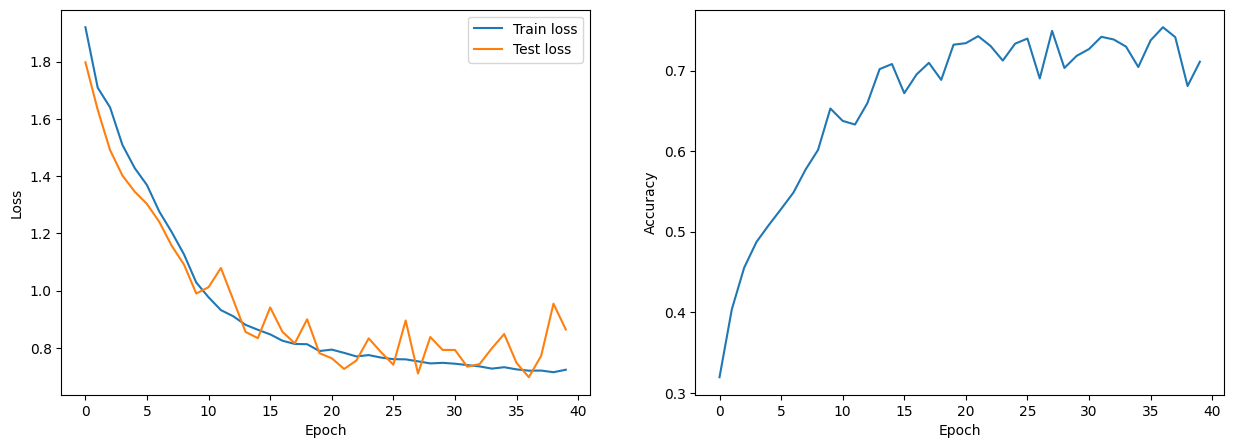

In [ ]:
config, model, train_losses, test_losses, accuracies, completed_epochs, current_image_size = load_experiment(f"{PATH}experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

### Load trained model

In [ ]:
# Load trained model
# --------------------
config, model, train_losses, test_losses, accuracies, completed_epochs, current_image_size = load_experiment(
    experiment_name= 'vit-with-40-epochs',
    checkpoint_name="model_final.pt",
    base_dir="experiments")

Using device: cpu
Model loaded successfully!


## Visualise intermediate output

In [ ]:
# Load trained model
# --------------------
config, model, train_losses, test_losses, accuracies, completed_epochs, current_image_size = load_experiment(
    experiment_name= 'vit-with-40-epochs',
    checkpoint_name="model_final.pt",
    base_dir="experiments")

# Or define a new untrained model
# --------------------
# model = ViTForClassfication(config)

# Specify train set for visualisations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Using device: cpu
Model loaded successfully!
Files already downloaded and verified


In [ ]:
### NEW FUNCTION START ###
#@title visualize PatchEmbeddings activations
@torch.no_grad()
def visualize_PatchEmbeddings_activations(model, dataset, device="cuda", output=None, num_images=30, visualize="conv_output", seed=None):
    """
    Visualize original images alongside intermediate outputs (e.g., after the convolution layer, patch embeddings, or flattened outputs)
    from the PatchEmbeddings module.

    Args:
        model (nn.Module): The model containing the PatchEmbeddings module.
        dataset (torch.utils.data.Dataset): The dataset to sample images from.
        device (str): The device to run the model on (default: "cuda").
        output (str, optional): Path to save the visualization. If None, the visualization is displayed.
        num_images (int): Number of images to visualize.
        visualize (str): The intermediate output to visualize: 'conv_output', 'patch_embeddings', or 'flattened_output'.
        seed (int, optional): Seed for reproducibility. Ensures the same images are visualized each time.
    """
    if seed is not None:
        torch.manual_seed(seed)  # Set seed for reproducibility

    model.eval()  # Set the model to evaluation mode

    # Define class names for CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
               'frog', 'horse', 'ship', 'truck')

    # Randomly select images from the dataset
    indices = torch.randperm(len(dataset))[:num_images]
    raw_images = [np.asarray(dataset[i][0]) for i in indices]  # Extract raw images
    labels = [dataset[i][1] for i in indices]  # Extract corresponding labels

    # Transform images for input into the model
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to Tensor
        transforms.Resize((32, 32)),  # Resize image to 32x32
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to mean 0 and std 1
    ])
    images = torch.stack([transform(image) for image in raw_images]).to(device)  # Stack images into a batch

    # Pass images through the model and get intermediate outputs
    model = model.to(device)  # Move model to the specified device
    patch_embeddings, conv_output, flattened_output = model.embedding.patch_embeddings(images, return_intermediate=True)

    # Select the desired output to visualize
    if visualize == "conv_output":
        output_to_visualize = conv_output.cpu()  # Visualization for conv_output
    elif visualize == "patch_embeddings":
        output_to_visualize = patch_embeddings.cpu()  # Visualization for patch_embeddings
    elif visualize == "flattened_output":
        output_to_visualize = flattened_output.cpu()  # Visualization for flattened_output
    else:
        raise ValueError("Invalid value for 'visualize'. Choose from 'conv_output', 'patch_embeddings', or 'flattened_output'.")

    # Determine the number of rows required
    num_rows = math.ceil(num_images / 3)  # 3 images per row
    fig, axes = plt.subplots(num_rows, 6, figsize=(20, num_rows * 4))  # 3 pairs (original, activations) per row

    for i in range(num_images):
        row, col = divmod(i, 3)  # Compute row and column indices for the subplot grid

        # Show the original image
        ax_orig = axes[row, col * 2]
        ax_orig.imshow(raw_images[i])  # Display original image
        ax_orig.set_title(f"gt: {classes[labels[i]]}", fontsize=10)  # Display ground truth class name
        ax_orig.axis("off")  # Remove axes for clean visualization

        # Show the activations
        ax_act = axes[row, col * 2 + 1]
        if visualize == "conv_output":
            # Conv output: Show as a heatmap of the first channel
            ax_act.imshow(output_to_visualize[i, 0].numpy(), cmap='jet')  # Display heatmap for conv_output
        elif visualize == "patch_embeddings":
            # Patch embeddings: Visualize as a grid of patches
            num_patches = output_to_visualize.size(1)  # Determine number of patches
            size = int(math.sqrt(num_patches))  # Determine grid size
            output_to_visualize_grid = output_to_visualize[i].view(size, size, -1).mean(dim=-1).numpy()  # Reshape and average
            ax_act.imshow(output_to_visualize_grid, cmap='jet')  # Display heatmap for patch_embeddings
        elif visualize == "flattened_output":
            # Flattened output: Visualize as a linear heatmap
            ax_act.imshow(output_to_visualize[i].numpy(), aspect='auto', cmap='jet')  # Display linear heatmap for flattened_output

        ax_act.set_title(f"Activation: {classes[labels[i]]}", fontsize=10)  # Set title for activations
        ax_act.axis("off")  # Remove axes for clean visualization

    # Hide unused subplots if num_images is not a multiple of 3
    for i in range(num_images, num_rows * 3):
        row, col = divmod(i, 3)
        axes[row, col * 2].axis("off")
        axes[row, col * 2 + 1].axis("off")

    plt.tight_layout()  # Adjust layout for clean spacing
    if output:
        plt.savefig(output)  # Save the visualization if output path is provided
    plt.show()  # Display the visualization
### NEW FUNCTION END ###

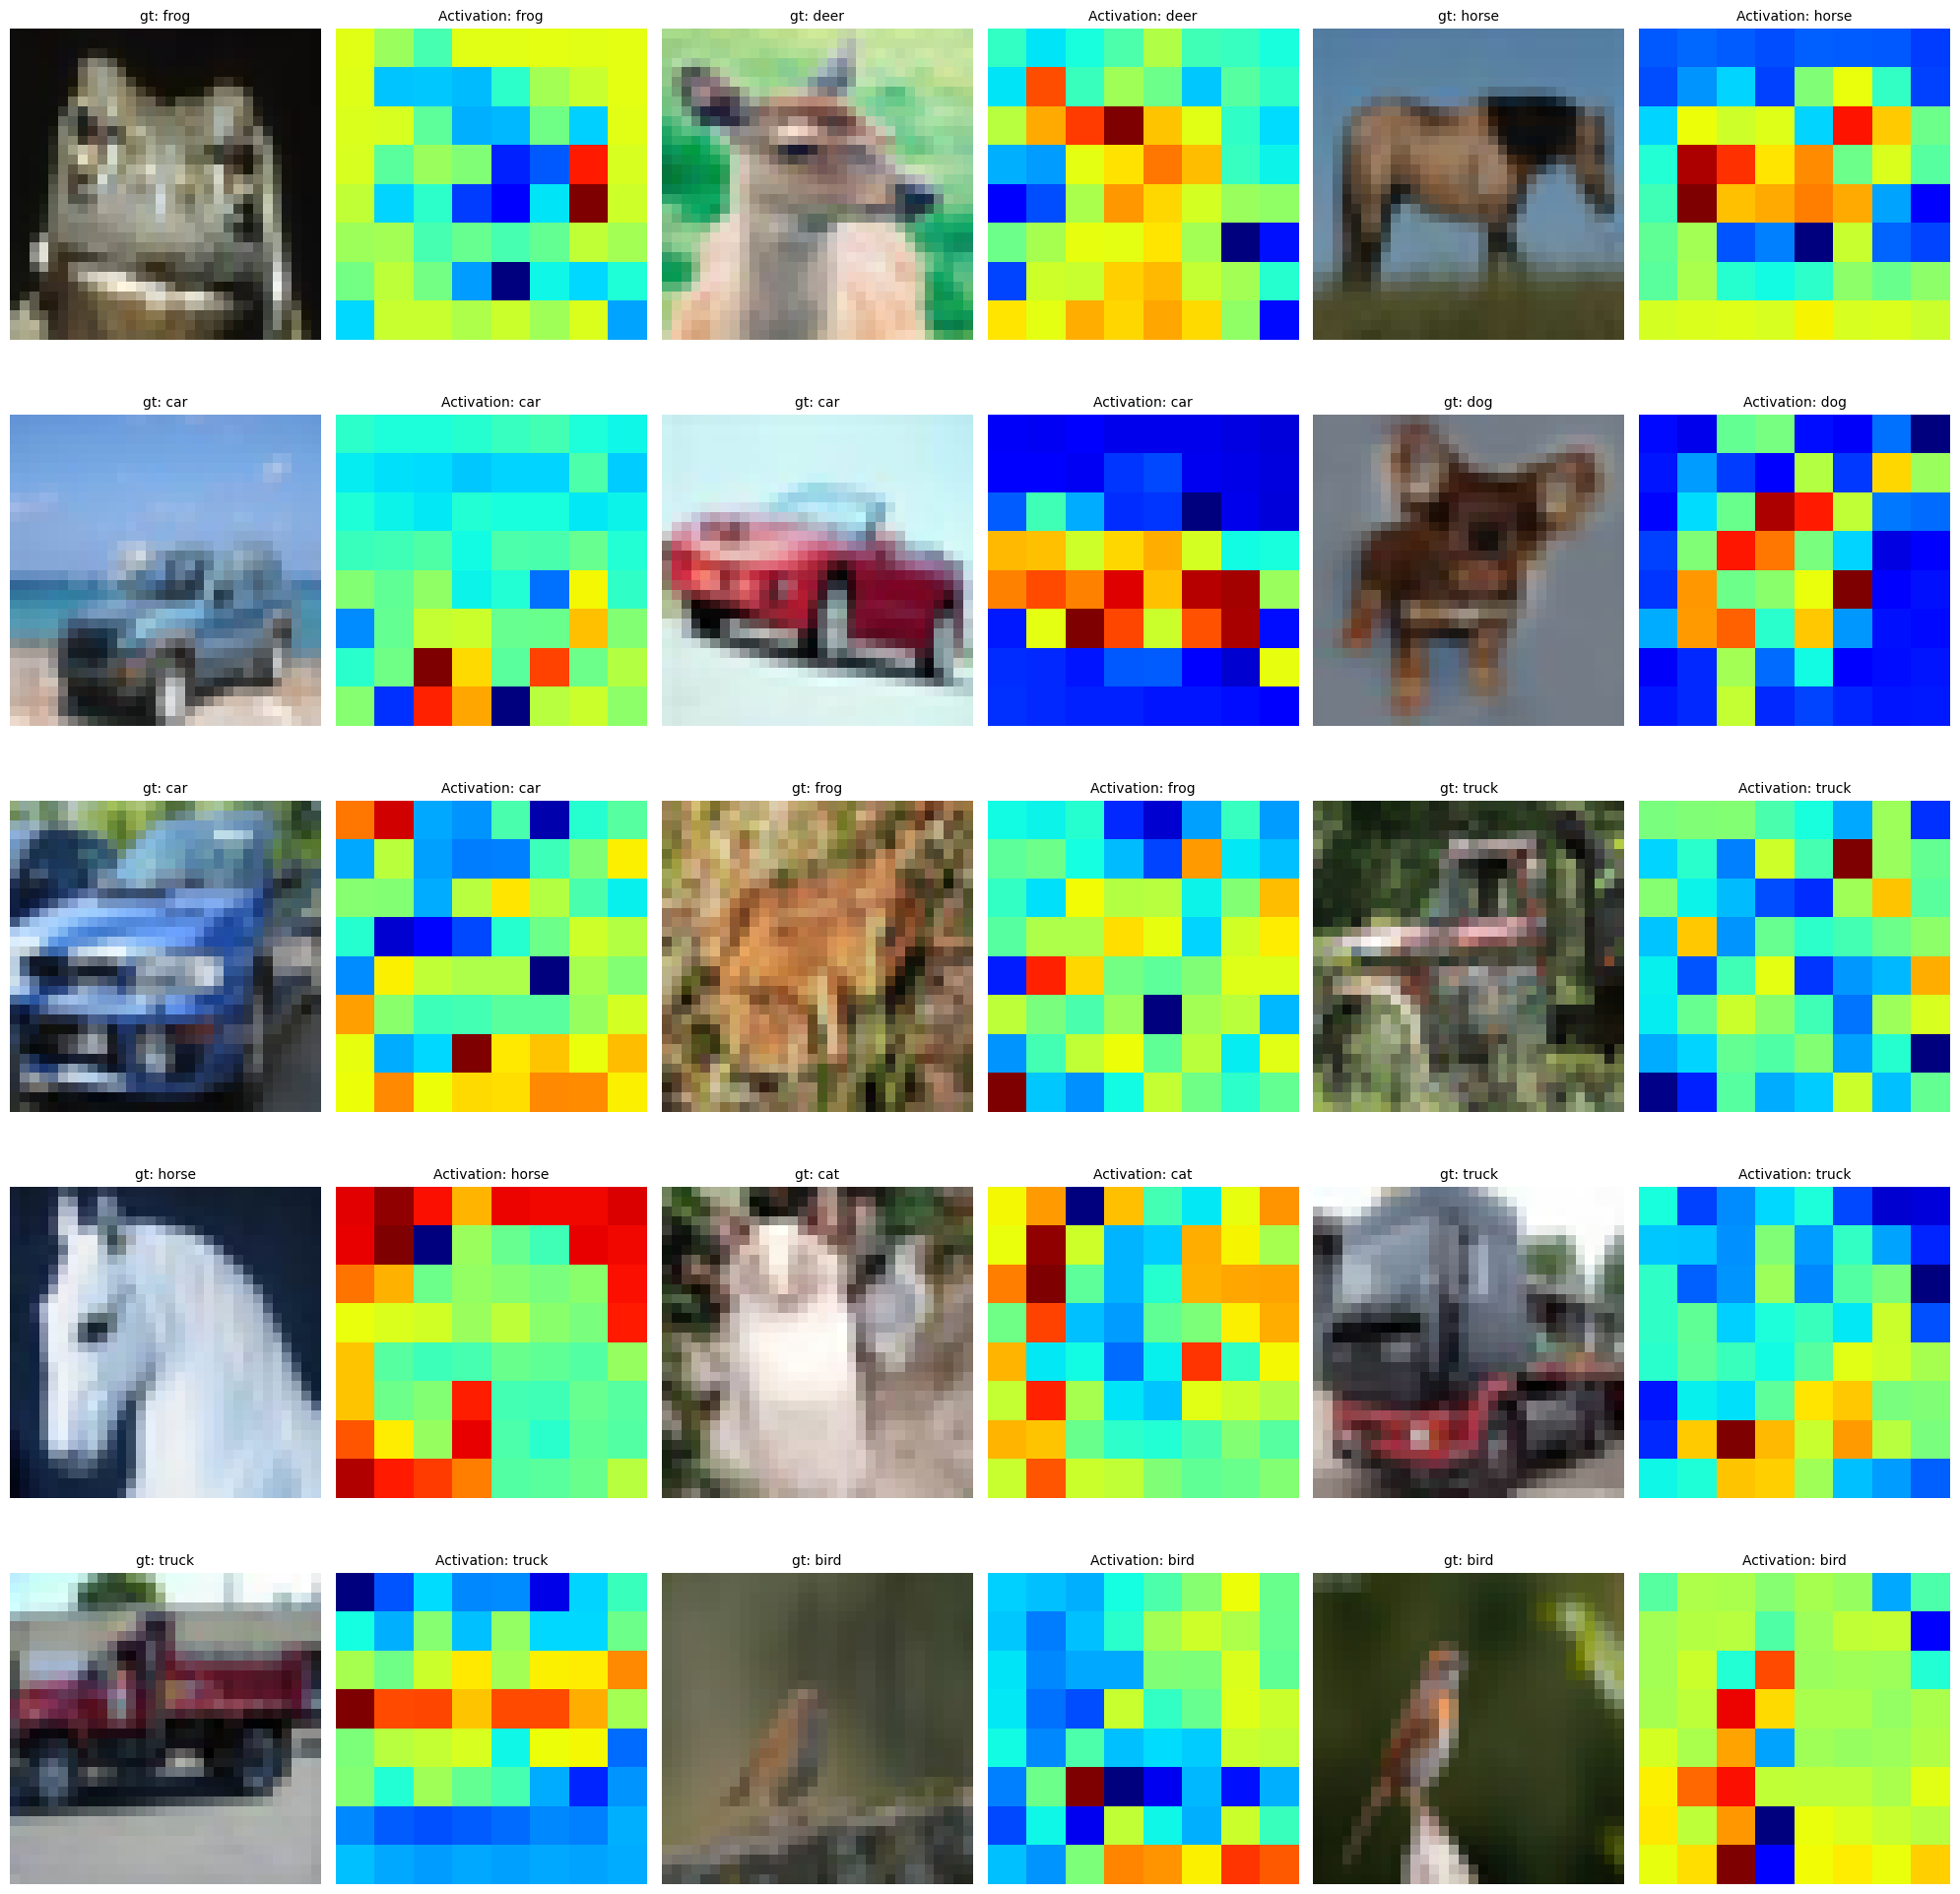

In [ ]:
visualize_PatchEmbeddings_activations(model, trainset, device="cpu", output=None, num_images=15, visualize="patch_embeddings", seed=43)

**Visualize PatchEmbeddings**

Anayse of the above visualisation. \
***Note*** : These image represents the activations, i.e. the output of the patch_embeddings layer applied to a given image. These activations depend on the input image.

> **`conv_output`**

The `conv_output` represents the intermediate feature map generated during the Linear Projection of Flattened Patches.  During this step, the input image is divided into fixed-size patches, and each patch is projected into a higher-dimensional embedding space. \
More precisely, the `conv_output` realises these 3 operations:

1. Input Image Preprocessing: The input image $\mathbf{x}$ is a tensor of size $H \times W \times C$, where:
  - $H$ and $W$: Height and width of the image.
  - $C$: Number of channels (e.g., 3 for RGB images).

  In our case, the input image is resized to $32 \times 32$, and $C = 3$.

2. Patch Extraction and Flattening: The input image is divided into patches of size $P \times P$ using a convolutional layer, where $P = 4$ in our case, meaning each patch is $4 \times 4$. The number of patches $N$ is calculated as $N = \frac{H}{P} \times \frac{W}{P}$  and $N=64$ in our case. The convolutional layer slides over the image with: Kernel size = $P \times P$, Stride = $P$.

3. Projection into Embedding Space: Each patch is projected into a feature vector of dimension $D$, where $D$ is the hidden size of the Transformer. This projection is achieved via the convolutional layer, which maps the input from $C$ channels to $D$ channels. In our case, $D = 48$.

- Finally, the `conv_output` as the shape $(B, D, H/P, W/P)$ where $B$: Batch size, $D$: Number of output feature channels (embedding dimension), $H/P, W/P$: Reduced spatial dimensions of the feature map. In our case we have : $ = (B, D, H/P, W/P) = (15, 48, 8, 8)$

**Analysis of the Visualization**
To visualise `conv_output`, each subplot represents the first channel dimension $D$ for a single image. We visualise a grid of size $(H/P, W/P)$. Patches with higher activation (intense colors) correspond to regions in the image with prominent features or textures. The spatial structure is evident, with the $8 \times 8$ grid representing the spatial layout of the patches.

> **`flattened_output`**

To prepare the data for the Transformer encoder, the 2D spatial structure of the patches is flattened. The spatial dimensions $H/P$ and $W/P$ are collapsed into a single sequence dimension $N$, representing the patches. The output is then transposed to the format $(B, N, D)$ for input into the Transformer.

**Analysis of the Visualization**
the `flattened_output` is visualized directly as a 2D heatmap, without reshaping into a square grid. Each subplot is of size $(D,N)$ for a single image.
The `flattened_output` is a representation of the image where each patch  has been "flattened" into a vector, with each patch corresponding to one row of the heatmap. Each column in the heatmap corresponds to one feature or dimension in the embedding space.

> **`patch_embeddings`**

`patch_embeddings` are the same as `flattened_output`, but properly transposed and normalized for Transformer input. It has a size of $(B, D, N)$

**Analysis of the Visualization**
Patches are reshaped into a square grid of size $(B,\sqrt{N},\sqrt{N},D)$ where $N$ is assumed to be a perfect square (e.g., 64 = 8×8). Averaging is applied along the hidden dimension $D$ to reduce the last dimension, resulting in: $(B,\sqrt{N},\sqrt{N})$ and for a single image $(\sqrt{N},\sqrt{N})$

In [ ]:
#@title visualize PatchEmbeddings filters

### NEW FUNCTION START ###
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

@torch.no_grad()
def visualize_embedding_filters(model, patch_size, n_components=28, color_mode="rgb"):
    """
    Visualize the principal components of the linear learned embedding filters
    (Figure 7 Left of the ViT Paper), with an optional color scale for grayscale visualization.

    Args:
        model (nn.Module): The trained Vision Transformer model.
        patch_size (int): The size of each patch (P x P).
        n_components (int): The number of principal components to visualize.
        color_mode (str): "rgb" for color visualization, "grayscale" for heatmap visualization.
    """
    # Extract the projection weights from the PatchEmbeddings module
    weights = model.embedding.patch_embeddings.projection.weight.cpu().numpy()  # Shape: (hidden_size=D, in_channels=C, P, P)

    # Reshape weights into a 2D matrix to apply PCA
    hidden_size, in_channels, P, P = weights.shape
    weights_reshaped = weights.reshape(hidden_size, -1)  # Shape: (hidden_size, in_channels * P * P)

    # Apply PCA to reduce dimensions
    pca = PCA(n_components)  # Extract the first n_components principal components

    # Transpose the weight matrix to shift the focus to spatial features:
    # Before transpose: weights_reshaped has shape (hidden_size, in_channels * P * P),
    # where each row corresponds to a single embedding vector for a patch.
    # After transpose: shape becomes (in_channels * P * P, hidden_size),
    # where each row now corresponds to spatial features across all embeddings.
    pca_components = pca.fit_transform(weights_reshaped.T).T  # Shape: (n_components, in_channels * P * P)
    # Perform PCA on the spatial features to identify the principal components:
    # - PCA reduces the dimensionality of the spatial features (rows of the transposed matrix).
    # - The output (pca_components) has shape (n_components, in_channels * P * P),
    #   where n_components corresponds to the number of principal components to visualize.

    # Reshape components back into image format
    pca_images = pca_components.reshape(-1, in_channels, patch_size, patch_size)  # Shape: (n_components, in_channels, P, P)

    # Set up the figure layout with gridspec
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(4, 8, width_ratios=[1]*7 + [0.1], wspace=0.4)  # Reserve space for colorbar

    for i in range(28):  # Adjust for the number of components
        ax = fig.add_subplot(gs[i // 7, i % 7])  # Place images in the grid
        if i < len(pca_images):
            # Reshape into image format
            img = np.transpose(pca_images[i], (1, 2, 0))  # (C, H, W) -> (H, W, C)

            # Normalize to range [0, 1]
            img = (img - img.min()) / (img.max() - img.min())

            if color_mode == "grayscale":
                # Average across channels to create a heatmap
                grayscale_img = img.mean(axis=-1) if img.shape[-1] > 1 else img[..., 0]
                im = ax.imshow(grayscale_img, cmap="viridis")  # Use a color map for grayscale visualization
            elif color_mode == "rgb":
                # RGB visualization (or multi-channel visualization)
                im = ax.imshow(img)
            else:
                raise ValueError(f"Invalid color_mode: {color_mode}. Choose 'rgb' or 'grayscale'.")

            ax.axis('off')  # Remove axes for clean visualization

    # Add the colorbar outside the grid for grayscale visualization
    if color_mode == "grayscale":
        cbar_ax = fig.add_subplot(gs[:, -1])  # Allocate the last column for the colorbar
        fig.colorbar(im, cax=cbar_ax, orientation='vertical')
        cbar_ax.set_ylabel("Intensity", rotation=90)

    plt.show()
### NEW FUNCTION END ###

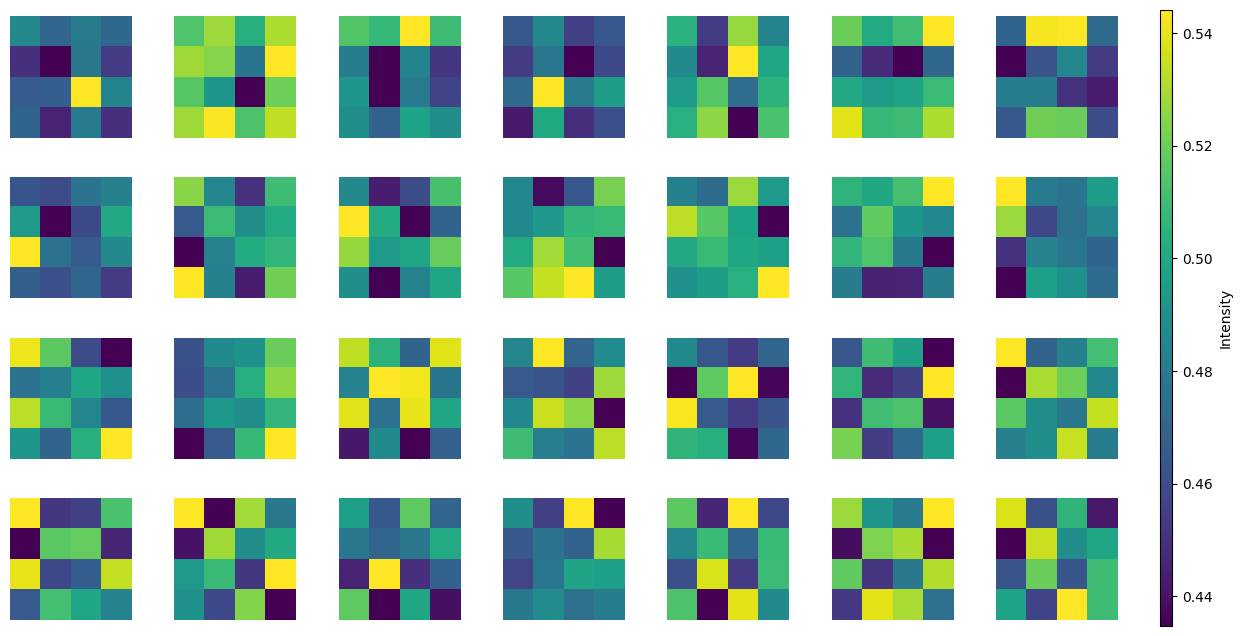

In [ ]:
# Example usage:
#visualize_embedding_filters (model, patch_size=4, color_mode="rgb")  # For RGB
visualize_embedding_filters(model, patch_size=4, color_mode="grayscale")  # For grayscale

***Note*** These images aims to reproduce "*figure 7 left*" on the ViT paper. These are not the activations but the weights learned from the PatchEmbeddings class. These weights are independent of the input image and capture the bases that the model uses to encode patches.

**Analyse of the visualisation**
The images represent the principal components of the embedding filters, revealing how the ViT encodes spatial and channel-level features in patches. Each image corresponds to a principal component, where the colors and patterns highlight the learned low-level features such as edges, textures, or contrasts. The colors in these images indicate the relative contribution of each spatial and channel dimension to the corresponding principal component. Bright colors (e.g., yellow) represent higher contributions (positive values), while darker colors (e.g., blue) signify lower contributions (negative values). Neutral colors (e.g., green) reflect near-zero contributions. Structured and diverse patterns suggest meaningful features, while uniform or noisy ones may indicate insufficient training or a lack of complexity in the dataset (e.g., CIFAR-10). Comparing across epochs or models can help assess the evolution of these features, as well-trained models typically exhibit interpretable filters resembling Gabor-like patterns, as seen in the ViT paper (Figure 7 Left). Quantitative analysis, like PCA variance explained, can provide further insights into the strength of these components.


In [ ]:
#@title visualize positionEmbedding similarity

### NEW FUNCTION START ###
from sklearn.metrics.pairwise import cosine_similarity

@torch.no_grad()
def visualize_positionEmbedding_similarity(model, title="Position Embedding Similarity"):
    """
    Visualize the cosine similarity between position embeddings of the patches.

    Args:
        model (nn.Module): The Vision Transformer model containing position embeddings.
        title (str): The title for the visualization.
    """
    # Step 1: Extract position embeddings from the model.
    # The position embeddings are learnable parameters that encode the spatial location of patches.
    # Exclude the [CLS] token embedding as it is used for classification and not spatial relations.
    # Shape of position_embeddings: (num_patches, hidden_size), where num_patches = total patches in the grid.
    position_embeddings = model.embedding.position_embeddings[0, 1:, :]  # Remove the [CLS] token (index 0).

    # Step 2: Compute cosine similarity between all pairs of position embeddings.
    # Cosine similarity measures the angular similarity between vectors, giving values in [-1, 1].
    # Using sklearn's `cosine_similarity` function, we compute the pairwise similarity.
    # Input shape: (num_patches, hidden_size), Output shape: (num_patches, num_patches),
    # where each cell (i, j) represents the similarity between the i-th and j-th patch embeddings.
    similarity_matrix = cosine_similarity(position_embeddings.cpu().numpy())  # Convert tensor to numpy.

    # Step 3: Reshape the similarity matrix into a 4D grid for visualization.
    # Assume the patches form a square grid (e.g., 8x8 for CIFAR-10 with 64 patches).
    # Reshape the similarity matrix into a 4D array: (rows, cols, rows, cols),
    # where each block represents similarity between patches at corresponding row-column positions.
    num_patches = int(np.sqrt(similarity_matrix.shape[0]))  # Compute grid size (e.g., sqrt(64) = 8).
    similarity_grid = similarity_matrix.reshape(num_patches, num_patches, num_patches, num_patches)

    # Step 4: Aggregate similarity values for better clarity.
    # Average across rows and columns to reduce dimensionality and highlight general trends.
    # The resulting 2D array has shape (rows, cols), where each cell represents the mean similarity
    # of patches in corresponding regions.
    similarity_grid = similarity_grid.mean(axis=(2, 3))

    # Step 5: Visualize the similarity grid as a heatmap.
    # A heatmap is a natural way to represent similarity, with colors indicating values (e.g., blue for low similarity,
    # yellow for high similarity).
    plt.figure(figsize=(8, 6))  # Set the figure size.
    plt.imshow(similarity_grid, cmap="viridis", aspect="equal")  # Use the "viridis" colormap for the heatmap.
    plt.colorbar(label="Cosine Similarity")  # Add a color bar to show the scale of similarity values.
    plt.title(title, fontsize=14)  # Add a title to the heatmap.
    plt.xlabel("Input Patch Column")  # Label the x-axis to indicate patch columns.
    plt.ylabel("Input Patch Row")  # Label the y-axis to indicate patch rows.
    plt.tight_layout()  # Adjust the layout to avoid overlapping elements.
    plt.show()  # Display the heatmap.

### NEW FUNCTION END ###

**Explanation of visualize_positionEmbedding_similarity function**

With this function, we try to recreate the image presented in "*Figure 7 center*" of the ViT paper.

1. Extract Position Embeddings

  ```position_embeddings = model.embedding.position_embeddings[0, 1:, :]```

  - We retrieve the learnable position embeddings from the ViT model.
  - The $[0, 1:, :]$ part excludes the [CLS] token, focusing only on patch embeddings.
  - The resulting shape is (num_patches, hidden_size) (e.g., $(64, D)$ for $64$ patches).

2. Initial Similarity Matrix : The initial similarity matrix is of size $(64,64)$:
  -  Each row represents a patch in the input sequence, indexed linearly from 0 to 63.
  - Each column corresponds to another patch in the same linear sequence.

  This matrix shows the cosine similarity between every pair of patches:

  ```
  Initial Similarity Matrix (64x64):
  [ [S(0,0), S(0,1), ..., S(0,63)],
      [S(1,0), S(1,1), ..., S(1,63)],
      ...
      [S(63,0), S(63,1), ..., S(63,63)] ]
  ```
  Here, $S(i,j)$ represents the cosine similarity between patch $i$ and patch $j$.

2. Reshaping the Similarity Matrix

  The similarity matrix $(64,64)$ is reshaped into $(8,8,8,8)$. This reshape divides the patches into their spatial rows and columns:
  - First two dimensions $(8, 8)$: Represent the grid positions $(row, column)$ of source patches.
  - Last two dimensions $(8, 8)$: Represent the grid positions $(row, column)$ of target patches.

  Example:
  ```
  Similarity Matrix Reshaped (8x8x8x8):
  [ For patch (0,0) as the source:
    [ [S(0,0), S(0,1), ..., S(0,7)],
      [S(0,8), S(0,9), ..., S(0,15)],
      ...
      [S(0,56), S(0,57), ..., S(0,63)] ],

    For patch (0,1) as the source:
    [ [S(1,0), S(1,1), ..., S(1,7)],
      [S(1,8), S(1,9), ..., S(1,15)],
      ...
      [S(1,56), S(1,57), ..., S(1,63)] ],

    ...
  ]
  ```
  Each $8\times8$ block corresponds to the similarity scores between one source patch and all target patches.


3. Averaging Across Target Patches

  To simplify visualization, the function averages across the target patch dimensions ($8\times8$):
  ```
  similarity_grid = similarity_matrix.reshape(8, 8, 8, 8).mean(axis=(2, 3))
  ```
  This produces a $(8,8)$ matrix where each entry represents the average similarity of one patch to all others.

  ```
  Example:

  Final Similarity Grid (8x8):
  [ [ Avg(S(0, *)), Avg(S(1, *)), ..., Avg(S(7, *)) ],
     [ Avg(S(8, *)), Avg(S(9, *)), ..., Avg(S(15, *)) ],
     ...
     [ Avg(S(56, *)), Avg(S(57, *)), ..., Avg(S(63, *)) ] ]

  ```





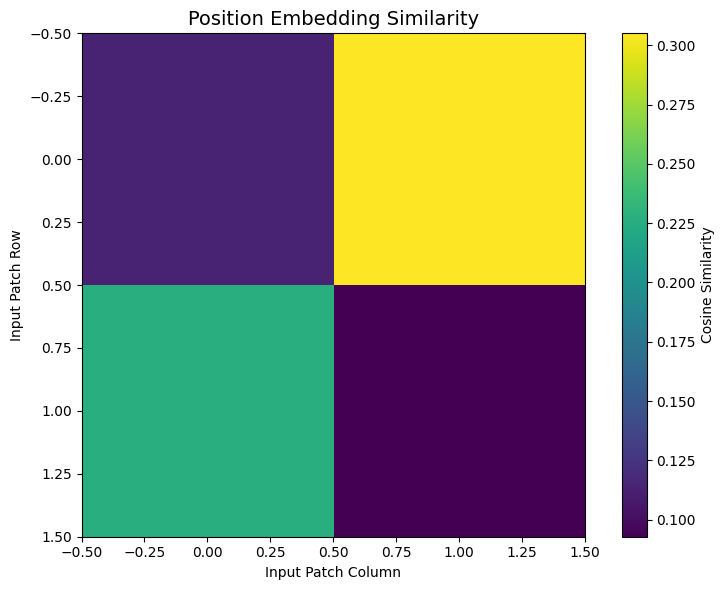

In [ ]:
# Example Usage
visualize_positionEmbedding_similarity(model)


**Visual Analise of the result obtained with visualize_positionEmbedding_similarity**

- Output shape: (num_patches, num_patches) where each cell $(i, j)$ represents the similarity between the $i$-th and $j$-th patch embeddings.

We clearly see that we do not obtain the same graph as the one in "*Figure 7 center*" of the ViT paper.

The difference can be attributed to several factors:

- Position Embedding Initialization: In our model, embeddings were initialized randomly and may not yet exhibit meaningful patterns. The ViT paper's embeddings were extensively trained on large datasets, like ImageNet, resulting in more structured and interpretable embeddings.
- Dataset and Training: The ViT paper utilized high-resolution datasets (e.g., ImageNet, JFT-300M) that foster sophisticated spatial relationships. In contrast, smaller datasets like CIFAR-10 (32x32 resolution) may lead to embeddings with less richness.
- Patch Resolution: Larger patches (e.g., 16x16 pixels) in the paper emphasize positional differences. Smaller patches, such as 4x4 for 32x32 images, may not vary enough to produce distinct positional relationships.
- Cosine Similarity: The heatmap in our visualization lacks the structured "yellow points" from the paper, as our embeddings may not have developed strong patch relationships during training.


## Visualise Attention

<img src="https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/summary.png" alt="Attention Mechanism" width="500">


In the context of Transformers, to visualise the attention we examine the connections between a **source token** (here, the `[CLS]` token) and all other **target tokens** in the sequence.

**Understanding the Attention Mechanism**

**1. Attention Scores = $QK^T$**
- The attention mechanism computes importance scores for every pair of tokens in a sequence.
- These scores indicate how much a **source token** (e.g., `[CLS]`) "attends to" a **target token** (e.g., a patch of the image or another token).
- The scores are normalized using a **softmax** to produce probabilities.

**2. Attention Matrices**
- The raw output of the attention mechanism is a matrix of size:
  ```
  (seq_len, seq_len) = (n,n) = QK^T in the schema above
  ```
  
  where each row corresponds to a **source token**, and each column corresponds to a **target token**.

  Example for a sequence of length 5 (seq_len = 5):

  $$
  \text{Attention Scores} =
  \begin{bmatrix}
  s_{[1 \rightarrow 1]} & s_{[1 \rightarrow 2]} & s_{[1 \rightarrow 3]} & s_{[1 \rightarrow 4]} & s_{[1 \rightarrow 5]} \\
  s_{[2 \rightarrow 1]} & s_{[2 \rightarrow 2]} & s_{[2 \rightarrow 3]} & s_{[2 \rightarrow 4]} & s_{[2 \rightarrow 5]} \\
  s_{[3 \rightarrow 1]} & s_{[3 \rightarrow 2]} & s_{[3 \rightarrow 3]} & s_{[3 \rightarrow 4]} & s_{[3 \rightarrow 5]} \\
  s_{[4 \rightarrow 1]} & s_{[4 \rightarrow 2]} & s_{[4 \rightarrow 3]} & s_{[4 \rightarrow 4]} & s_{[4 \rightarrow 5]} \\
  s_{[5 \rightarrow 1]} & s_{[5 \rightarrow 2]} & s_{[5 \rightarrow 3]} & s_{[5 \rightarrow 4]} & s_{[5 \rightarrow 5]}
  \end{bmatrix}
  $$

  - Each element $s_{[i \rightarrow j]}$ represents how much the **source token $i$** attends to the **target token $j$**.

**3. The `[CLS]` token as the source**
- By selecting only the first row of this matrix, we retrieve the attention scores **from the `[CLS]` token (source)** to **all tokens in the sequence**.

  Example for row 1 (`[CLS]` as the source):
  
  $$
  [s_{[1 \rightarrow 1]}, s_{[1 \rightarrow 2]}, s_{[1 \rightarrow 3]}, s_{[1 \rightarrow 4]}, s_{[1 \rightarrow 5]}]
  $$

  Here:
  - $s_{[1 \rightarrow 1]}$ is the attention that `[CLS]` gives to itself (self-attention).
  - $s_{[1 \rightarrow 2]}, s_{[1 \rightarrow 3]}, \dots$ are the attentions `[CLS]` gives to other tokens.

In this case:
- **Source**: The `[CLS]` token (index `0` in the sequence).
- **Target**: All other tokens in the sequence, including `[CLS]` itself.

When we write:

```python
attention_maps = attention_maps[:, :, 0, :]
```

It means:
- We are selecting the **attention scores from the `[CLS]` token (index `0`)**.
- These scores correspond to **how `[CLS]` attends to all other tokens in the sequence** (all columns).

**Explanation of `1` in `attention_maps = attention_maps[:, :, 0, 1:]`**

1. **`attention_maps[:, :, 0, :]`**:
   - Selects the attention scores for the **first row** of the attention map (the `[CLS]` token as the source).
   - These scores describe how `[CLS]` attends to **all tokens in the sequence**, including itself.

2. **`attention_maps[:, :, 0, 1:]`**:
   - Excludes the self-attention score $s_{[CLS \rightarrow CLS]}$ (i.e., `[CLS]` attending to itself).
   - Retains only the scores indicating **how `[CLS]` attends to the patches in the input image** (tokens at indices 1 through $\text{seq\_len}$).

This step ensures that we focus only on the relationships between `[CLS]` and the patches, excluding its self-attention score which is not informative in this context.



In [ ]:
@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the Vision Transformer for a batch of CIFAR-10 test images.

    Args:
        model (nn.Module): The Vision Transformer model with attention capabilities.
        output (str, optional): If provided, saves the visualization as an image file. Otherwise, it displays the plot.
        device (str): Device to run the model and data on ("cuda" for GPU, "cpu" for CPU).
    """

    # Put the model in evaluation mode to disable dropout layers and batch normalization
    model.eval()

    # Step 1: Load CIFAR-10 test images
    num_images = 30  # Number of images to visualize

    # Load the CIFAR-10 test set
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    # CIFAR-10 class labels for reference
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    # Randomly select `num_images` test images and their corresponding labels
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]

    # Step 2: Prepare Image Transformation
    # Retrieve the current image size and patch size from the model configuration
    current_image_size = model.config.get("image_size", 32)  # Default to 32x32 if not found
    patch_size = model.config.get("patch_size", 4)  # Default patch size of 4

    # Apply transformations: resizing, converting to tensor, and normalizing
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((current_image_size, current_image_size)), ### NEW ###
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization to mean 0 and std 1
    ])

    # Convert the list of images into a tensor and move to the specified device
    images = torch.stack([test_transform(image) for image in raw_images]).to(device)
    model = model.to(device)

    # Step 3: Forward Pass Through Model
    # Perform a forward pass with the model to obtain logits and attention maps
    # The output_attentions=True flag ensures attention maps are returned
    logits, attention_maps = model(images, current_image_size=current_image_size, output_attentions=True) ### NEW ###
    # attention_maps = list containing the attention scores generated by the Transformer's various layers.
    # Each element of this list is a tensor with the form: (batch_size,num_heads,seq_len,seq_len)
    # (seq_len = number of patches + 1 for token [CLS]).
    predictions = torch.argmax(logits, dim=1) # Get the predicted class index for each image (highest logits)

    # Step 4: Process Attention Maps
    # Combine attention maps from all layers and heads into a single tensor
    # attention_maps: [batch_size, num_layers, num_heads, seq_len, seq_len]
    attention_maps = torch.cat(attention_maps, dim=1) # Shape: (batch_size, num_heads * num_layers, seq_len, seq_len)
    # Assemble all the attention outputs in each block into a single tensor.
    # Create a large tensor where the size of the heads multiplies the number of layers.

    # Select attention maps corresponding to the [CLS] token
    # [CLS] token attends to all other tokens (image patches) in the sequence
    attention_maps = attention_maps[:, :, 0, 1:]  # Exclude [CLS] itself

    # Average attention maps over all heads to get a single map per layer
    attention_maps = attention_maps.mean(dim=1)  # Shape: (batch_size, seq_len - 1)

    # Dynamically calculate the number of patches based on the image size and patch size ### NEW ###
    num_patches = (current_image_size // patch_size) ** 2 ### NEW ###
    size = int(math.sqrt(num_patches))  # Calculate the side length of the patch grid (e.g., 8x8 for 64 patches)
    # Since the patches are square (e.g., 8×8), the total number of patches can be used to infer the height and width of the patch grid.

    # Reshape attention maps to a square grid of patches
    attention_maps = attention_maps.view(-1, size, size)  # Shape: (batch_size, height, width)
    # .view reshapes the attention_maps tensor into a 2D grid for visualization or further processing.

    # Upscale attention maps to match the original image size (32x32)
    attention_maps = attention_maps.unsqueeze(1)  # Add a channel dimension for interpolation
    attention_maps = F.interpolate(attention_maps, size=(current_image_size, current_image_size), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)  # Remove the added channel dimension

    # Step 5: Visualization Setup
    fig = plt.figure(figsize=(20, 10))

    # Create a binary mask for visualizing attention only on the right half
    mask = np.concatenate([np.ones((current_image_size, current_image_size)),
                           np.zeros((current_image_size, current_image_size))], axis=1)

    # Step 6: Generate Subplots for Each Image
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])  # 6 rows, 5 columns grid
        # Duplicate the image side-by-side for visualization purposes
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)

        # Prepare the attention map for visualization on the right side only
        extended_attention_map = np.concatenate((np.zeros((current_image_size, current_image_size)),
                                                 attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask == 1, extended_attention_map)  # Mask left side
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')  # Overlay the attention map with transparency

        # Step 7: Display Ground Truth and Prediction
        gt = classes[labels[i]]  # Ground truth label
        pred = classes[predictions[i]]  # Predicted label
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt == pred else "red"))

    # Step 8: Save or Display Results
    if output:
        plt.savefig(output)
    plt.show()


Files already downloaded and verified


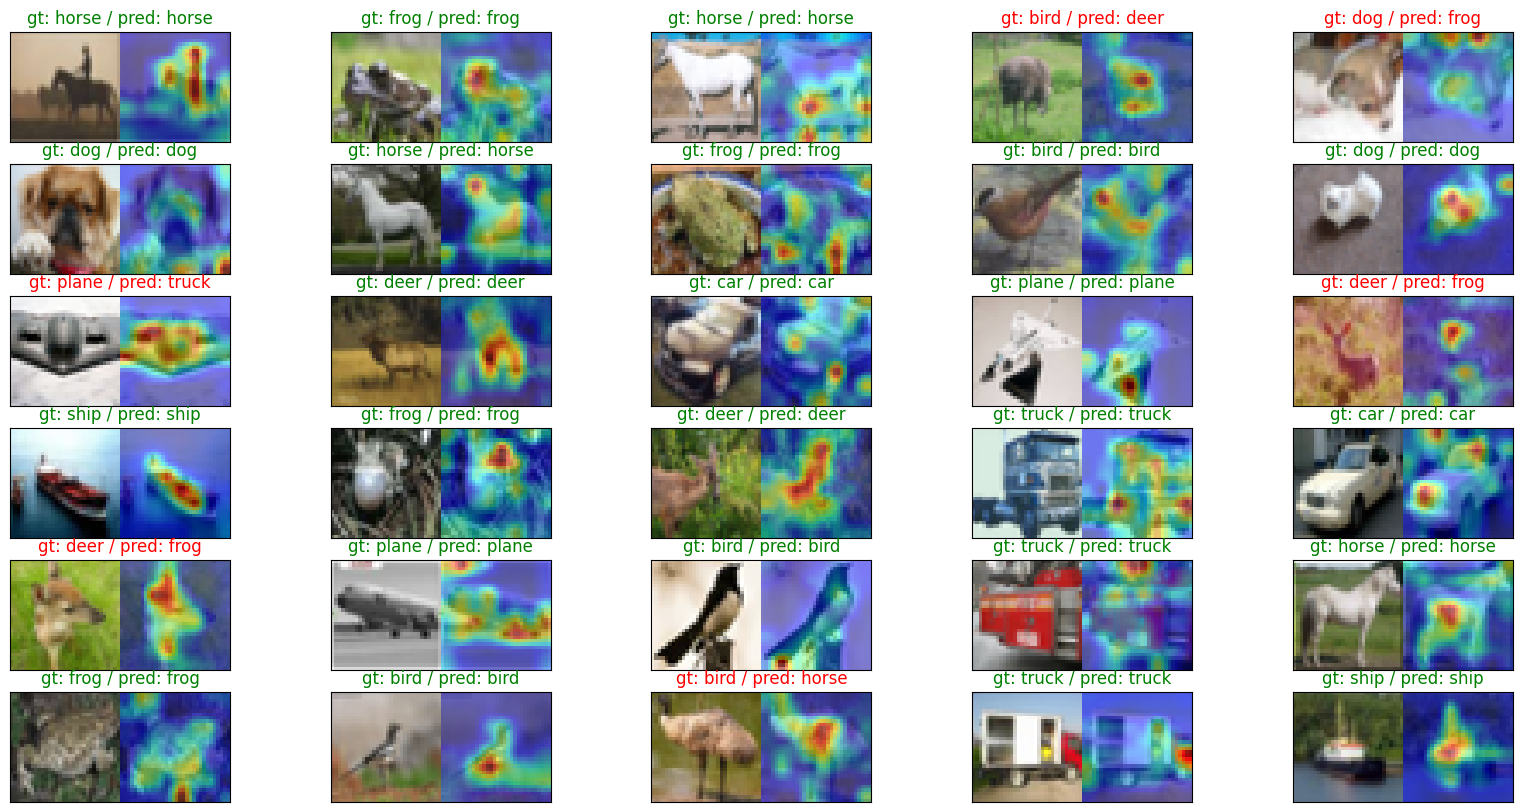

In [ ]:
visualize_attention(model, output=None, device="cpu")